In [14]:
#!/usr/bin/env python
"""
Optimized code for processing source distance and mass distributions,
calculating the median and 68% credible interval for each source/instrument,
rounding numerical outputs to two decimal places, and saving the results
in a CSV file. If the user selects 'all' instruments then the code uses the 
actual instrument (e.g. MAXI, XRT, RXTE_PCA) for the instrument column.

Reputable sources and documentation:
- NumPy: https://numpy.org/doc/
- SciPy (norm.pdf): https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
- Pandas: https://pandas.pydata.org/pandas-docs/stable/
- tqdm (loading bar): https://tqdm.github.io/
- Python sqlite3 (if needed): https://docs.python.org/3/library/sqlite3.html
"""

import os
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm

# -----------------------------
# Helper Functions
# -----------------------------
def mass_weight_gauss(mass):
    """Gaussian prior weight for the mass (Ozel et al. 2010)."""
    mean = 7.8   # Ozel et al. 2010
    sigma = 1.2  # Ozel et al. 2010
    return norm.pdf(mass, loc=mean, scale=sigma)

def quantile_index(pdf_values, q):
    """
    Return the index at which the normalized cumulative sum of the PDF 
    reaches or exceeds the quantile q.
    """
    pdf_values = pdf_values / np.sum(pdf_values)
    cumulative = np.cumsum(pdf_values)
    return np.searchsorted(cumulative, q)

def round_sig(x):
    """Round number x to two decimal places."""
    # Handle the zero case:
    if x == 0:
        return 0.0
    return float(f"{x:.2f}")

# -----------------------------
# Settings and Input Files
# -----------------------------
# Mapping of source codes to full names.
sources_dict = {
    'xte_j1652-453': 'XTE J1652-453',
    'j1348_630': 'MAXI J1348-630',
    'xte_j1908_094': 'XTE J1908+094',
    'igr_j17091-3624': 'IGR J17091-3624',
    'j1820+070': 'MAXI J1820+070',
    'j1836-194': 'MAXI J1836-194',
    'grs_1739_278': 'GRS 1739-278',
    'J0637_430': 'MAXI J0637-430',
    'h1743-322': 'H 1743-322',
    'j1910_0546': 'Swift J1910.2-0546',
    'J1828_249': 'MAXI J1828-249',
    'j1842-112': 'Swift J1842.5-1124',
    'j1659_152': 'MAXI J1659-152',
    'j1305_704': 'MAXI J1305-704',
    'xte_j1752_223': 'XTE J1752-223',
    'gx339-4': 'GX 339-4',
    'xte_j1650-500': 'XTE J1650-500',
    'xte_j1859+226': 'XTE J1859+226',
    'J1727_203': 'MAXI J1727-203',
    '4U1543-475': '4U1543-475',
    'J1539-6227': 'Swift J1539.2-6227',
    'xte_j1748-2848': 'XTE J1748-2848',
    'xte_j1720-318': 'XTE J1720-318',
    'xte_j1817-330': 'XTE J1817-330',
    'xte_j1818-245': 'XTE J1818-245',
    'j1543_564': 'MAXI J1543-564',
    'j1803-298': 'MAXI J1803-298',
    "j1727-1613": "Swift J1727.8-1613"
}

# Base data directory.
dataDir = '/disk/data/youssef/data'
# List of instruments to process.
# To use all available instruments, set instruments = ['all']
instruments = ['all']  # or for example: ['maxi', 'xrt'] or ['all']

# Source list files for different instruments.
maxiListFile = '/disk/data/youssef/scripts/xrb_distance/source_lists/maxi_sources_all_inc_soft.txt'
xrtListFile =  '/disk/data/youssef/scripts/xrb_distance/source_lists/xrt_sources_all_inc_soft.txt'
rxteListFile = '/disk/data/youssef/scripts/xrb_distance/source_lists/rxte_pca_sources_all_inc_soft.txt'
softOnlylistFile = '/disk/data/youssef/scripts/xrb_distance/source_lists/soft_only_sources.txt'

# Exclusion lists.
exclude = []  # General exclude list
exclude_specific_inst = [
    ('j1305_704','MAXI'), ('j1659_152','MAXI'), ('j1659_152','XRT'),
    ('j1305_704','XRT'), ('xte_j1752_223','MAXI'), ('j1543_564','XRT'),
    ('j1820+070','XRT'), ('gx339-4','MAXI'), ('gx339-4','XRT'),
    ('h1743-322','XRT'), ('j1727-1613','XRT')
]

# -----------------------------
# Prepare CSV Results Container
# -----------------------------
results = []  # Each element is a dictionary that becomes a row in the CSV

# -----------------------------
# Processing: Two Branches
# -----------------------------
# (A) When instrument is not "all": Process each instrument’s folder.
# (B) When instrument is "all": Loop over all files in each source folder and 
#      aggregate data per actual instrument found in the directory name.

for instrument in instruments:
    # Read soft-only source names.
    with open(softOnlylistFile, 'r') as f:
        soft_only_sources = f.read().splitlines()

    # Determine source list for this instrument.
    if instrument.lower() == 'all':
        # Combine lists from all instruments.
        with open(maxiListFile, 'r') as f:
            sources_maxi = f.read().splitlines()
        with open(xrtListFile, 'r') as f:
            sources_xrt = f.read().splitlines()
        with open(rxteListFile, 'r') as f:
            sources_rxte = f.read().splitlines()
        sources = sorted(set(sources_maxi + sources_xrt + sources_rxte),
                         key=lambda s: sources_dict.get(s, s))
    else:
        if instrument.lower() == 'maxi':
            list_file = maxiListFile
        elif instrument.lower() == 'xrt':
            list_file = xrtListFile
        elif instrument.lower() in ['rxte', 'rxte_pca']:
            list_file = rxteListFile
        else:
            raise ValueError('Unsupported instrument. Use maxi, xrt, rxte_pca, or all.')
        with open(list_file, 'r') as f:
            sources = f.read().splitlines()

    # Warn if any source is missing from sources_dict.
    for src in sources:
        if src not in sources_dict:
            print(f"Warning: Source {src} not found in sources_dict.")

    # Sort sources by full name.
    sources = sorted(sources, key=lambda s: sources_dict.get(s, s))

    # -----------------------------
    # Case (A): Specific Instrument (not "all")
    # -----------------------------
    if instrument.lower() != 'all':
        # Use a progress bar for the list of sources.
        for source in tqdm(sources, desc=f"Processing {instrument.upper()} sources"):
            # Exclude if source is in the general list or if its (source, instrument) pair is excluded.
            if source in exclude or (source, instrument.upper()) in exclude_specific_inst:
                continue

            sourceDirectory = os.path.join(dataDir, source)
            # When a specific instrument is chosen, assume data are in dataDir/source/instrument
            searchDir = os.path.join(sourceDirectory, instrument)
            overall_histogram = None
            distance_bins = None
            masses_bins = None
            distance_step = None
            mass_step = None

            # Walk the directory tree.
            for dirName, _, fileList in os.walk(searchDir):
                # Skip unwanted directories.
                if 'no' in dirName or 'old' in dirName:
                    continue
                for fname in fileList:
                    if fname in ['plot_data.npz', 'plot_data_combined.npz']:
                        filePath = os.path.join(dirName, fname)
                        try:
                            plot_data = np.load(filePath)
                        except Exception as e:
                            print(f"Could not load {filePath}: {e}")
                            continue

                        # Set bins and steps once.
                        if distance_bins is None:
                            distance_bins = plot_data['distance_bins']
                            masses_bins = plot_data['masses']
                            distance_step = distance_bins[1] - distance_bins[0]
                            mass_step = masses_bins[1] - masses_bins[0]

                        # Decide which histogram to use.
                        if source in soft_only_sources:
                            if 'weighted_histograms_soft_np' in plot_data.files:
                                hist = plot_data['weighted_histograms_soft_np']
                            else:
                                print(f"Warning: 'weighted_histograms_soft_np' not found in {filePath}")
                                continue
                        else:
                            if 'weighted_histograms_np' in plot_data.files:
                                hist = plot_data['weighted_histograms_np']
                            elif all(key in plot_data.files for key in ['weighted_histograms_soft_np',
                                                                          'weighted_histograms_trans_np']):
                                soft = plot_data['weighted_histograms_soft_np']
                                trans = plot_data['weighted_histograms_trans_np']
                                masses = masses_bins
                                weights = mass_weight_gauss(masses)
                                hist = (soft * trans) / weights[:, np.newaxis]
                            else:
                                print(f"Warning: No acceptable histogram in {filePath}")
                                continue

                        norm_factor = np.sum(hist) * distance_step * mass_step
                        if norm_factor == 0:
                            continue
                        hist_norm = hist / norm_factor
                        if overall_histogram is None:
                            overall_histogram = hist_norm
                        else:
                            overall_histogram += hist_norm

            # Skip if no valid data were found.
            if overall_histogram is None or distance_bins is None or masses_bins is None:
                print(f"No valid data for source {source} with instrument {instrument.upper()}.")
                continue

            # Re-normalize aggregated histogram.
            overall_histogram = overall_histogram / (np.sum(overall_histogram) * distance_step * mass_step)
            dist_midpoints = distance_bins[:-1] + 0.5 * distance_step
            mass_midpoints = masses_bins[:-1] + 0.5 * mass_step
            distance_pdf = np.sum(overall_histogram, axis=0) * mass_step
            mass_pdf_marginal = np.sum(overall_histogram, axis=1) * distance_step

            idx_med = quantile_index(distance_pdf, 0.5)
            idx_low = quantile_index(distance_pdf, 0.16)
            idx_high = quantile_index(distance_pdf, 0.84)
            median_distance = dist_midpoints[idx_med]
            lower_distance = median_distance - dist_midpoints[idx_low]
            upper_distance = dist_midpoints[idx_high] - median_distance

            idx_med_mass = quantile_index(mass_pdf_marginal, 0.5)
            idx_low_mass = quantile_index(mass_pdf_marginal, 0.16)
            idx_high_mass = quantile_index(mass_pdf_marginal, 0.84)
            median_mass = mass_midpoints[idx_med_mass]
            lower_mass = median_mass - mass_midpoints[idx_low_mass]
            upper_mass = mass_midpoints[idx_high_mass] - median_mass

            # For a specific instrument, the actual instrument is just the one provided.
            actual_inst = instrument.upper()

            # Add a flag to indicate whether the estimate is soft-only or combined.
            soft_flag = "soft only" if source in soft_only_sources else "combined"

            results.append({
                'source_code': source,
                'source_name': sources_dict.get(source, source),
                'instrument': actual_inst,
                'soft_only': soft_flag,
                'median_distance': round_sig(median_distance),
                'lower_distance_error': round_sig(lower_distance),
                'upper_distance_error': round_sig(upper_distance),
                'median_mass': round_sig(median_mass),
                'lower_mass_error': round_sig(lower_mass),
                'upper_mass_error': round_sig(upper_mass)
            })

    # -----------------------------
    # Case (B): instrument == "all" -> aggregate per actual instrument
    # -----------------------------
    else:
        # Here we assume files from any instrument may reside in dataDir/source.
        for source in tqdm(sources, desc="Processing ALL sources"):
            # Exclude source if it is in the general exclude list.
            if source in exclude:
                continue

            sourceDirectory = os.path.join(dataDir, source)
            # Dictionary to hold data for each actual instrument.
            inst_data = {}  # key: actual instrument (e.g., 'MAXI'), value: dict with aggregated info

            # Walk over the entire source directory.
            for dirName, _, fileList in os.walk(sourceDirectory):
                # Skip unwanted directories.
                if 'no' in dirName or 'old' in dirName:
                    continue
                for fname in fileList:
                    if fname in ['plot_data.npz', 'plot_data_combined.npz']:
                        filePath = os.path.join(dirName, fname)
                        try:
                            plot_data = np.load(filePath)
                        except Exception as e:
                            print(f"Could not load {filePath}: {e}")
                            continue

                        # Determine the actual instrument from the directory name.
                        actual_inst = None
                        for inst in ['maxi', 'xrt', 'rxte_pca']:
                            if inst in dirName.lower():
                                actual_inst = inst.upper()
                                break
                        if actual_inst is None:
                            continue

                        # Initialize entry for this instrument if needed.
                        if actual_inst not in inst_data:
                            inst_data[actual_inst] = {
                                'overall_histogram': None,
                                'distance_bins': None,
                                'masses_bins': None,
                                'distance_step': None,
                                'mass_step': None
                            }
                        # Set bins/steps if not yet set.
                        if inst_data[actual_inst]['distance_bins'] is None:
                            inst_data[actual_inst]['distance_bins'] = plot_data['distance_bins']
                            inst_data[actual_inst]['masses_bins'] = plot_data['masses']
                            inst_data[actual_inst]['distance_step'] = plot_data['distance_bins'][1] - plot_data['distance_bins'][0]
                            inst_data[actual_inst]['mass_step'] = plot_data['masses'][1] - plot_data['masses'][0]

                        # Decide which histogram to use.
                        if source in soft_only_sources:
                            if 'weighted_histograms_soft_np' in plot_data.files:
                                hist = plot_data['weighted_histograms_soft_np']
                            else:
                                continue
                        else:
                            if 'weighted_histograms_np' in plot_data.files:
                                hist = plot_data['weighted_histograms_np']
                            elif all(key in plot_data.files for key in ['weighted_histograms_soft_np',
                                                                          'weighted_histograms_trans_np']):
                                soft = plot_data['weighted_histograms_soft_np']
                                trans = plot_data['weighted_histograms_trans_np']
                                masses = inst_data[actual_inst]['masses_bins']
                                weights = mass_weight_gauss(masses)
                                hist = (soft * trans) / weights[:, np.newaxis]
                            else:
                                continue

                        distance_step = inst_data[actual_inst]['distance_step']
                        mass_step = inst_data[actual_inst]['mass_step']
                        norm_factor = np.sum(hist) * distance_step * mass_step
                        if norm_factor == 0:
                            continue
                        hist_norm = hist / norm_factor
                        if inst_data[actual_inst]['overall_histogram'] is None:
                            inst_data[actual_inst]['overall_histogram'] = hist_norm
                        else:
                            inst_data[actual_inst]['overall_histogram'] += hist_norm

            # Process aggregated data for each actual instrument.
            for actual_inst, data in inst_data.items():
                # Before processing, check if the source/instrument combination is excluded.
                if (source, actual_inst) in exclude_specific_inst:
                    continue

                overall_histogram = data['overall_histogram']
                distance_bins = data['distance_bins']
                masses_bins = data['masses_bins']
                distance_step = data['distance_step']
                mass_step = data['mass_step']
                if overall_histogram is None:
                    continue

                overall_histogram = overall_histogram / (np.sum(overall_histogram) * distance_step * mass_step)
                dist_midpoints = distance_bins[:-1] + 0.5 * distance_step
                mass_midpoints = masses_bins[:-1] + 0.5 * mass_step
                distance_pdf = np.sum(overall_histogram, axis=0) * mass_step
                mass_pdf_marginal = np.sum(overall_histogram, axis=1) * distance_step

                idx_med = quantile_index(distance_pdf, 0.5)
                idx_low = quantile_index(distance_pdf, 0.16)
                idx_high = quantile_index(distance_pdf, 0.84)
                median_distance = dist_midpoints[idx_med]
                lower_distance = median_distance - dist_midpoints[idx_low]
                upper_distance = dist_midpoints[idx_high] - median_distance

                idx_med_mass = quantile_index(mass_pdf_marginal, 0.5)
                idx_low_mass = quantile_index(mass_pdf_marginal, 0.16)
                idx_high_mass = quantile_index(mass_pdf_marginal, 0.84)
                median_mass = mass_midpoints[idx_med_mass]
                lower_mass = median_mass - mass_midpoints[idx_low_mass]
                upper_mass = mass_midpoints[idx_high_mass] - median_mass

                # Add soft_only flag based on whether the source is in the soft-only list.
                soft_flag = "soft only" if source in soft_only_sources else "combined"

                results.append({
                    'source_code': source,
                    'source_name': sources_dict.get(source, source),
                    'instrument': actual_inst,
                    'soft_only': soft_flag,
                    'median_distance': round_sig(median_distance),
                    'lower_distance_error': round_sig(lower_distance),
                    'upper_distance_error': round_sig(upper_distance),
                    'median_mass': round_sig(median_mass),
                    'lower_mass_error': round_sig(lower_mass),
                    'upper_mass_error': round_sig(upper_mass)
                })

# -----------------------------
# Save Results to CSV
# -----------------------------
results_df = pd.DataFrame(results)
output_csv = 'source_distance_mass_results.csv'
results_df.to_csv(output_csv, index=False)
print(f"Results saved to {output_csv}")


Processing ALL sources:   0%|          | 0/27 [00:00<?, ?it/s]

Processing ALL sources: 100%|██████████| 27/27 [00:25<00:00,  1.05it/s]

Results saved to source_distance_mass_results.csv


In [2]:
#!/usr/bin/env python
"""
Optimized code for processing source distance and mass distributions,
calculating the median and 68% credible interval for each source/instrument,
rounding numerical outputs to two decimal places, applying a bias correction
to the soft state probability (using a Pareto distribution by default), and 
saving the results in a CSV file. If the user selects 'all' instruments then 
the code uses the actual instrument (e.g. MAXI, XRT, RXTE_PCA) for the instrument 
column.

Reputable sources and documentation:
- NumPy: https://numpy.org/doc/
- SciPy (norm.pdf, pareto): https://docs.scipy.org/doc/scipy/reference/
- Pandas: https://pandas.pydata.org/pandas-docs/stable/
- tqdm (loading bar): https://tqdm.github.io/
- Python sqlite3 (if needed): https://docs.python.org/3/library/sqlite3.html
"""

import os
import numpy as np
import pandas as pd
from scipy.stats import norm, pareto
from tqdm import tqdm

# -----------------------------
# Helper Functions
# -----------------------------
def mass_weight_gauss(mass):
    """Gaussian prior weight for the mass (Ozel et al. 2010)."""
    mean = 7.8   # Ozel et al. 2010
    sigma = 1.2  # Ozel et al. 2010
    return norm.pdf(mass, loc=mean, scale=sigma)

def quantile_index(pdf_values, q):
    """
    Return the index at which the normalized cumulative sum of the PDF 
    reaches or exceeds the quantile q.
    """
    pdf_values = pdf_values / np.sum(pdf_values)
    cumulative = np.cumsum(pdf_values)
    return np.searchsorted(cumulative, q)

def round_sig(x):
    """Round number x to two decimal places."""
    if x == 0:
        return 0.0
    return float(f"{x:.2f}")

def apply_bias_correction(soft_hist, distance_bins, distance_step, dist='pareto', renormalize=False, **params):
    """
    Apply bias correction to the soft histogram by dividing by the PDF 
    of the specified distribution evaluated at the distance midpoints.
    
    Parameters:
      soft_hist: 2D numpy array of the soft histogram.
      distance_bins: 1D array of distance bin edges.
      distance_step: Scalar step in distance.
      dist: string indicating which distribution to use (default 'pareto').
      renormalize: Boolean flag. If True, re-normalize the evaluated PDF over the 
                   given distance range.
      **params: additional parameters for the distribution. By default, for 'pareto'
                we use b=0.8 and loc=-13 (but these can be overridden).
                
    Returns:
      corrected_soft: 2D array, bias-corrected along the distance axis.
    """
    # Compute distance midpoints from bin edges.
    dist_midpoints = distance_bins[:-1] + 0.5 * distance_step
    if dist == 'pareto':
        b = params.get('b', 0.8)
        loc = params.get('loc', -13)
        distribution = pareto(b=b, loc=loc)
    else:
        distribution = params.get('distribution')
        if distribution is None:
            raise ValueError("No valid distribution specified for bias correction.")
    # Evaluate the PDF at the distance midpoints.
    correction_factors = distribution.pdf(dist_midpoints)
    if renormalize:
        # Re-normalize the correction factors over the range of distances.
        total = np.sum(correction_factors) * distance_step
        correction_factors = correction_factors / total
    epsilon = 1e-12  # avoid division by zero
    corrected_soft = soft_hist / (correction_factors[np.newaxis, :] + epsilon)
    return corrected_soft

# -----------------------------
# Settings and Input Files
# -----------------------------
# Mapping of source codes to full names.
sources_dict = {
    'xte_j1652-453': 'XTE J1652-453',
    'j1348_630': 'MAXI J1348-630',
    'xte_j1908_094': 'XTE J1908+094',
    'igr_j17091-3624': 'IGR J17091-3624',
    'j1820+070': 'MAXI J1820+070',
    'j1836-194': 'MAXI J1836-194',
    'grs_1739_278': 'GRS 1739-278',
    'J0637_430': 'MAXI J0637-430',
    'h1743-322': 'H 1743-322',
    'j1910_0546': 'Swift J1910.2-0546',
    'J1828_249': 'MAXI J1828-249',
    'j1842-112': 'Swift J1842.5-1124',
    'j1659_152': 'MAXI J1659-152',
    'j1305_704': 'MAXI J1305-704',
    'xte_j1752_223': 'XTE J1752-223',
    'gx339-4': 'GX 339-4',
    'xte_j1650-500': 'XTE J1650-500',
    'xte_j1859+226': 'XTE J1859+226',
    'J1727_203': 'MAXI J1727-203',
    '4U1543-475': '4U1543-475',
    'J1539-6227': 'Swift J1539.2-6227',
    'xte_j1748-2848': 'XTE J1748-2848',
    'xte_j1720-318': 'XTE J1720-318',
    'xte_j1817-330': 'XTE J1817-330',
    'xte_j1818-245': 'XTE J1818-245',
    'j1543_564': 'MAXI J1543-564',
    'j1803-298': 'MAXI J1803-298',
    "j1727-1613": "Swift J1727.8-1613"
}

# Base data directory.
dataDir = '/disk/data/youssef/data'
# List of instruments to process.
# To use all available instruments, set instruments = ['all']
instruments = ['all']  # e.g., ['maxi', 'xrt'] or ['all']

# Source list files for different instruments.
maxiListFile = '/disk/data/youssef/scripts/xrb_distance/source_lists/maxi_sources_all_inc_soft.txt'
xrtListFile =  '/disk/data/youssef/scripts/xrb_distance/source_lists/xrt_sources_all_inc_soft.txt'
rxteListFile = '/disk/data/youssef/scripts/xrb_distance/source_lists/rxte_pca_sources_all_inc_soft.txt'
softOnlylistFile = '/disk/data/youssef/scripts/xrb_distance/source_lists/soft_only_sources.txt'

# Exclusion lists.
exclude = []  # General exclude list
exclude_specific_inst = [
    ('j1305_704','MAXI'), ('j1659_152','MAXI'), ('j1659_152','XRT'),
    ('j1305_704','XRT'), ('xte_j1752_223','MAXI'), ('j1543_564','XRT'),
    ('j1820+070','XRT'), ('gx339-4','MAXI'), ('gx339-4','XRT'),
    ('h1743-322','XRT'), ('j1727-1613','XRT')
]

# Set a flag to control bias correction re-normalization.
RE_NORMALIZE = False  # Set to True to re-normalize the Pareto PDF over the data range.

# -----------------------------
# Prepare CSV Results Container
# -----------------------------
results = []  # Each element is a dictionary that becomes a row in the CSV

# -----------------------------
# Processing: Two Branches
# -----------------------------
# (A) When instrument is not "all": Process each instrument’s folder.
# (B) When instrument is "all": Loop over all files in each source folder and 
#      aggregate data per actual instrument found in the directory name.

for instrument in instruments:
    # Read soft-only source names.
    with open(softOnlylistFile, 'r') as f:
        soft_only_sources = f.read().splitlines()

    # Determine source list for this instrument.
    if instrument.lower() == 'all':
        with open(maxiListFile, 'r') as f:
            sources_maxi = f.read().splitlines()
        with open(xrtListFile, 'r') as f:
            sources_xrt = f.read().splitlines()
        with open(rxteListFile, 'r') as f:
            sources_rxte = f.read().splitlines()
        sources = sorted(set(sources_maxi + sources_xrt + sources_rxte),
                         key=lambda s: sources_dict.get(s, s))
    else:
        if instrument.lower() == 'maxi':
            list_file = maxiListFile
        elif instrument.lower() == 'xrt':
            list_file = xrtListFile
        elif instrument.lower() in ['rxte', 'rxte_pca']:
            list_file = rxteListFile
        else:
            raise ValueError('Unsupported instrument. Use maxi, xrt, rxte_pca, or all.')
        with open(list_file, 'r') as f:
            sources = f.read().splitlines()

    # Warn if any source is missing from sources_dict.
    for src in sources:
        if src not in sources_dict:
            print(f"Warning: Source {src} not found in sources_dict.")

    # Sort sources by full name.
    sources = sorted(sources, key=lambda s: sources_dict.get(s, s))

    # -----------------------------
    # Case (A): Specific Instrument (not "all")
    # -----------------------------
    if instrument.lower() != 'all':
        for source in tqdm(sources, desc=f"Processing {instrument.upper()} sources"):
            if source in exclude or (source, instrument.upper()) in exclude_specific_inst:
                continue

            sourceDirectory = os.path.join(dataDir, source)
            searchDir = os.path.join(sourceDirectory, instrument)
            overall_histogram = None
            distance_bins = None
            masses_bins = None
            distance_step = None
            mass_step = None

            for dirName, _, fileList in os.walk(searchDir):
                if 'no' in dirName or 'old' in dirName:
                    continue
                for fname in fileList:
                    if fname in ['plot_data.npz', 'plot_data_combined.npz']:
                        filePath = os.path.join(dirName, fname)
                        try:
                            plot_data = np.load(filePath)
                        except Exception as e:
                            print(f"Could not load {filePath}: {e}")
                            continue

                        if distance_bins is None:
                            distance_bins = plot_data['distance_bins']
                            masses_bins = plot_data['masses']
                            distance_step = distance_bins[1] - distance_bins[0]
                            mass_step = masses_bins[1] - masses_bins[0]

                        # For soft-only sources, first divide the soft spectrum by weights,
                        # then apply bias correction.
                        if source in soft_only_sources:
                            if 'weighted_histograms_soft_np' in plot_data.files:
                                soft = plot_data['weighted_histograms_soft_np']
                                masses = masses_bins
                                weights = mass_weight_gauss(masses)
                                soft = apply_bias_correction(soft, distance_bins, distance_step,
                                                             renormalize=RE_NORMALIZE)
                                hist = soft
                            else:
                                print(f"Warning: 'weighted_histograms_soft_np' not found in {filePath}")
                                continue
                        else:
                            if all(key in plot_data.files for key in ['weighted_histograms_soft_np',
                                                                          'weighted_histograms_trans_np']):
                                soft = plot_data['weighted_histograms_soft_np']
                                trans = plot_data['weighted_histograms_trans_np']
                                masses = masses_bins
                                weights = mass_weight_gauss(masses)
                                soft = apply_bias_correction(soft, distance_bins, distance_step,
                                                             renormalize=RE_NORMALIZE)
                                hist = soft * trans / weights[:, np.newaxis]
                            else:
                                print(f"Warning: No acceptable histogram in {filePath}")
                                continue

                        norm_factor = np.sum(hist) * distance_step * mass_step
                        if norm_factor == 0:
                            continue
                        hist_norm = hist / norm_factor
                        if overall_histogram is None:
                            overall_histogram = hist_norm
                        else:
                            overall_histogram += hist_norm

            if overall_histogram is None or distance_bins is None or masses_bins is None:
                print(f"No valid data for source {source} with instrument {instrument.upper()}.")
                continue

            overall_histogram = overall_histogram / (np.sum(overall_histogram) * distance_step * mass_step)
            dist_midpoints = distance_bins[:-1] + 0.5 * distance_step
            mass_midpoints = masses_bins[:-1] + 0.5 * mass_step
            distance_pdf = np.sum(overall_histogram, axis=0) * mass_step
            mass_pdf_marginal = np.sum(overall_histogram, axis=1) * distance_step

            idx_med = quantile_index(distance_pdf, 0.5)
            idx_low = quantile_index(distance_pdf, 0.16)
            idx_high = quantile_index(distance_pdf, 0.84)
            median_distance = dist_midpoints[idx_med]
            lower_distance = median_distance - dist_midpoints[idx_low]
            upper_distance = dist_midpoints[idx_high] - median_distance

            idx_med_mass = quantile_index(mass_pdf_marginal, 0.5)
            idx_low_mass = quantile_index(mass_pdf_marginal, 0.16)
            idx_high_mass = quantile_index(mass_pdf_marginal, 0.84)
            median_mass = mass_midpoints[idx_med_mass]
            lower_mass = median_mass - mass_midpoints[idx_low_mass]
            upper_mass = mass_midpoints[idx_high_mass] - median_mass

            actual_inst = instrument.upper()
            soft_flag = "soft only" if source in soft_only_sources else "combined"

            results.append({
                'source_code': source,
                'source_name': sources_dict.get(source, source),
                'instrument': actual_inst,
                'soft_only': soft_flag,
                'median_distance': round_sig(median_distance),
                'lower_distance_error': round_sig(lower_distance),
                'upper_distance_error': round_sig(upper_distance),
                'median_mass': round_sig(median_mass),
                'lower_mass_error': round_sig(lower_mass),
                'upper_mass_error': round_sig(upper_mass)
            })

    # -----------------------------
    # Case (B): instrument == "all" -> aggregate per actual instrument
    # -----------------------------
    else:
        for source in tqdm(sources, desc="Processing ALL sources"):
            if source in exclude:
                continue

            sourceDirectory = os.path.join(dataDir, source)
            inst_data = {}

            for dirName, _, fileList in os.walk(sourceDirectory):
                if 'no' in dirName or 'old' in dirName:
                    continue
                for fname in fileList:
                    if fname in ['plot_data.npz', 'plot_data_combined.npz']:
                        filePath = os.path.join(dirName, fname)
                        try:
                            plot_data = np.load(filePath)
                        except Exception as e:
                            print(f"Could not load {filePath}: {e}")
                            continue

                        actual_inst = None
                        for inst in ['maxi', 'xrt', 'rxte_pca']:
                            if inst in dirName.lower():
                                actual_inst = inst.upper()
                                break
                        if actual_inst is None:
                            continue

                        if actual_inst not in inst_data:
                            inst_data[actual_inst] = {
                                'overall_histogram': None,
                                'distance_bins': None,
                                'masses_bins': None,
                                'distance_step': None,
                                'mass_step': None
                            }
                        if inst_data[actual_inst]['distance_bins'] is None:
                            inst_data[actual_inst]['distance_bins'] = plot_data['distance_bins']
                            inst_data[actual_inst]['masses_bins'] = plot_data['masses']
                            inst_data[actual_inst]['distance_step'] = plot_data['distance_bins'][1] - plot_data['distance_bins'][0]
                            inst_data[actual_inst]['mass_step'] = plot_data['masses'][1] - plot_data['masses'][0]

                        if source in soft_only_sources:
                            if 'weighted_histograms_soft_np' in plot_data.files:
                                soft = plot_data['weighted_histograms_soft_np']
                                masses = inst_data[actual_inst]['masses_bins']
                                weights = mass_weight_gauss(masses)
                                soft = apply_bias_correction(soft,
                                                             inst_data[actual_inst]['distance_bins'],
                                                             inst_data[actual_inst]['distance_step'],
                                                             renormalize=RE_NORMALIZE)
                                hist = soft
                            else:
                                continue
                        else:
                            if all(key in plot_data.files for key in ['weighted_histograms_soft_np',
                                                                          'weighted_histograms_trans_np']):
                                soft = plot_data['weighted_histograms_soft_np']
                                masses = inst_data[actual_inst]['masses_bins']
                                weights = mass_weight_gauss(masses)
                                soft = apply_bias_correction(soft,
                                                             inst_data[actual_inst]['distance_bins'],
                                                             inst_data[actual_inst]['distance_step'],
                                                             renormalize=RE_NORMALIZE)
                                trans = plot_data['weighted_histograms_trans_np']
                                hist = soft * trans / weights[:, np.newaxis]
                            else:
                                continue

                        distance_step = inst_data[actual_inst]['distance_step']
                        mass_step = inst_data[actual_inst]['mass_step']
                        norm_factor = np.sum(hist) * distance_step * mass_step
                        if norm_factor == 0:
                            continue
                        hist_norm = hist / norm_factor
                        if inst_data[actual_inst]['overall_histogram'] is None:
                            inst_data[actual_inst]['overall_histogram'] = hist_norm
                        else:
                            inst_data[actual_inst]['overall_histogram'] += hist_norm

            for actual_inst, data in inst_data.items():
                if (source, actual_inst) in exclude_specific_inst:
                    continue

                overall_histogram = data['overall_histogram']
                distance_bins = data['distance_bins']
                masses_bins = data['masses_bins']
                distance_step = data['distance_step']
                mass_step = data['mass_step']
                if overall_histogram is None:
                    continue

                overall_histogram = overall_histogram / (np.sum(overall_histogram) * distance_step * mass_step)
                dist_midpoints = distance_bins[:-1] + 0.5 * distance_step
                mass_midpoints = masses_bins[:-1] + 0.5 * mass_step
                distance_pdf = np.sum(overall_histogram, axis=0) * mass_step
                mass_pdf_marginal = np.sum(overall_histogram, axis=1) * distance_step

                idx_med = quantile_index(distance_pdf, 0.5)
                idx_low = quantile_index(distance_pdf, 0.16)
                idx_high = quantile_index(distance_pdf, 0.84)
                median_distance = dist_midpoints[idx_med]
                lower_distance = median_distance - dist_midpoints[idx_low]
                upper_distance = dist_midpoints[idx_high] - median_distance

                idx_med_mass = quantile_index(mass_pdf_marginal, 0.5)
                idx_low_mass = quantile_index(mass_pdf_marginal, 0.16)
                idx_high_mass = quantile_index(mass_pdf_marginal, 0.84)
                median_mass = mass_midpoints[idx_med_mass]
                lower_mass = median_mass - mass_midpoints[idx_low_mass]
                upper_mass = mass_midpoints[idx_high_mass] - median_mass

                soft_flag = "soft only" if source in soft_only_sources else "combined"

                results.append({
                    'source_code': source,
                    'source_name': sources_dict.get(source, source),
                    'instrument': actual_inst,
                    'soft_only': soft_flag,
                    'median_distance': round_sig(median_distance),
                    'lower_distance_error': round_sig(lower_distance),
                    'upper_distance_error': round_sig(upper_distance),
                    'median_mass': round_sig(median_mass),
                    'lower_mass_error': round_sig(lower_mass),
                    'upper_mass_error': round_sig(upper_mass)
                })

# -----------------------------
# Save Results to CSV
# -----------------------------
results_df = pd.DataFrame(results)
output_csv = 'source_distance_mass_results_corrected.csv'
results_df.to_csv(output_csv, index=False)
print(f"Results saved to {output_csv}")


Processing ALL sources:   0%|          | 0/27 [00:00<?, ?it/s]

Processing ALL sources: 100%|██████████| 27/27 [00:27<00:00,  1.01s/it]

Results saved to source_distance_mass_results_corrected.csv


In [3]:
#!/usr/bin/env python
"""
This script reads the CSV file 'source_distance_mass_results_corrected.csv' produced 
by the previous code, constructs an RA/Dec dictionary by querying SIMBAD for each unique 
source name (using a fallback wildcard query if needed), and appends these coordinates as new 
columns to the CSV output. An alias dictionary is used to handle alternative source names 
(e.g. mapping "XTE J1748-2848" to "XTE J1748-288"). The updated CSV file is saved as 
'source_distance_mass_results_with_coords.csv'.

Reputable sources and documentation:
- Pandas: https://pandas.pydata.org/pandas-docs/stable/
- Astroquery SIMBAD: https://astroquery.readthedocs.io/en/latest/simbad/simbad.html
- SIMBAD: http://simbad.u-strasbg.fr/simbad/
"""

import time
import pandas as pd
from astroquery.simbad import Simbad

# Configure SIMBAD to return RA and Dec in decimal degrees using the new field names.
Simbad.add_votable_fields('ra', 'dec')
Simbad.ROW_LIMIT = 1

# Define an alias dictionary for problematic source names.
# Map "XTE J1748-2848" to the commonly accepted "XTE J1748-288".
alias_dict = {
    "XTE J1748-2848": "XTE J1748-288"
}

# Read the previously generated CSV file.
input_csv = 'source_distance_mass_results_corrected.csv'
df = pd.read_csv(input_csv)

# Create an RA/Dec dictionary for each unique source name.
coord_dict = {}
unique_sources = df['source_name'].unique()

print("Querying SIMBAD for coordinates...")
for source in unique_sources:
    # Use the alias if available; otherwise, use the original source name.
    query_name = alias_dict.get(source, source)
    ra, dec = None, None
    try:
        result = Simbad.query_object(query_name)
        # If no result is returned, try a fallback wildcard query.
        if result is None:
            print(f"{source}: No direct result. Trying wildcard search...")
            result = Simbad.query_object(f"*{query_name}*")
        if result is not None and 'ra' in result.colnames and 'dec' in result.colnames:
            # Extract the first row's RA and Dec (in decimal degrees).
            ra = result['ra'][0]
            dec = result['dec'][0]
            print(f"{source} (queried as {query_name}): RA={ra}, Dec={dec}")
        else:
            print(f"{source} (queried as {query_name}): No result found in SIMBAD after fallback.")
    except Exception as e:
        print(f"{source} (queried as {query_name}): Error during query ({e}).")
    coord_dict[source] = (ra, dec)
    time.sleep(1)  # Pause between queries

# Append the RA and Dec values to the DataFrame using the dictionary.
df['ra'] = df['source_name'].map(lambda x: coord_dict.get(x, (None, None))[0])
df['dec'] = df['source_name'].map(lambda x: coord_dict.get(x, (None, None))[1])

# Save the updated DataFrame to a new CSV file.
output_csv = 'source_distance_mass_results_with_coords.csv'
df.to_csv(output_csv, index=False)
print(f"Updated CSV saved as {output_csv}")


Querying SIMBAD for coordinates...
GRS 1739-278 (queried as GRS 1739-278): RA=265.6667916666667, Dec=-27.747972222222224
GX 339-4 (queried as GX 339-4): RA=255.7057818297, Dec=-48.78974665404001
H 1743-322 (queried as H 1743-322): RA=266.564984875, Dec=-32.23357222222222
IGR J17091-3624 (queried as IGR J17091-3624): RA=257.2817083333333, Dec=-36.40713888888889
MAXI J0637-430 (queried as MAXI J0637-430): RA=99.09829166666667, Dec=-42.86780555555556
MAXI J1348-630 (queried as MAXI J1348-630): RA=207.05307847350997, Dec=-63.27491918978
MAXI J1543-564 (queried as MAXI J1543-564): RA=235.82231989182998, Dec=-56.41364413875
MAXI J1659-152 (queried as MAXI J1659-152): RA=254.75700000000003, Dec=-15.257980555555555
MAXI J1727-203 (queried as MAXI J1727-203): RA=261.971, Dec=-20.389
MAXI J1803-298 (queried as MAXI J1803-298): RA=270.92083333333335, Dec=-29.80388888888888
MAXI J1820+070 (queried as MAXI J1820+070): RA=275.09142659019994, Dec=7.1853569054
MAXI J1828-249 (queried as MAXI J1828-249

In [1]:
#!/usr/bin/env python
"""
Optimized code for processing source distance and mass distributions,
calculating the median and 68% credible interval for each source/instrument,
applying a bias correction to the soft state probability (using a Pareto distribution by default),
converting the heliocentric distance axis to Galactocentric coordinates using source RA/Dec (queried via SIMBAD),
aggregating the 2D histograms on a common GC grid, and saving the results in a CSV file.
If the user selects 'all' instruments then the code uses the actual instrument (e.g. MAXI, XRT, RXTE_PCA)
for the instrument column.

Reputable sources and documentation:
- NumPy: https://numpy.org/doc/
- SciPy (norm.pdf, pareto): https://docs.scipy.org/doc/scipy/reference/
- Pandas: https://pandas.pydata.org/pandas-docs/stable/
- tqdm (loading bar): https://tqdm.github.io/
- Astroquery SIMBAD: https://astroquery.readthedocs.io/en/latest/simbad/simbad.html
- Astropy Coordinates: https://docs.astropy.org/en/stable/coordinates/
- Matplotlib: https://matplotlib.org/stable/contents.html
"""

import os
import time
import numpy as np
import pandas as pd
from scipy.stats import norm, pareto
from tqdm import tqdm

# For SIMBAD queries and coordinate transformations.
from astroquery.simbad import Simbad
import astropy.units as u
from astropy.coordinates import SkyCoord, Galactocentric
import matplotlib.pyplot as plt

# -----------------------------
# Helper Functions
# -----------------------------
def mass_weight_gauss(mass):
    """Gaussian prior weight for the mass (Ozel et al. 2010)."""
    mean = 7.8   # Ozel et al. 2010
    sigma = 1.2  # Ozel et al. 2010
    return norm.pdf(mass, loc=mean, scale=sigma)

def quantile_index(pdf_values, q):
    """
    Return the index at which the normalized cumulative sum of the PDF 
    reaches or exceeds the quantile q.
    """
    pdf_values = pdf_values / np.sum(pdf_values)
    cumulative = np.cumsum(pdf_values)
    return np.searchsorted(cumulative, q)

def round_sig(x):
    """Round number x to two decimal places."""
    if x == 0:
        return 0.0
    return float(f"{x:.2f}")

def apply_bias_correction(soft_hist, distance_bins, distance_step, dist='pareto', renormalize=False, **params):
    """
    Apply bias correction to the soft histogram by dividing by the PDF 
    of the specified distribution evaluated at the distance midpoints.
    """
    # Compute distance midpoints from bin edges.
    dist_midpoints = distance_bins[:-1] + 0.5 * distance_step
    if dist == 'pareto':
        b = params.get('b', 0.8)
        loc = params.get('loc', -13)
        distribution = pareto(b=b, loc=loc)
    else:
        distribution = params.get('distribution')
        if distribution is None:
            raise ValueError("No valid distribution specified for bias correction.")
    # Evaluate the PDF at the distance midpoints.
    correction_factors = distribution.pdf(dist_midpoints)
    if renormalize:
        total = np.sum(correction_factors) * distance_step
        correction_factors = correction_factors / total
    epsilon = 1e-12  # avoid division by zero
    corrected_soft = soft_hist / (correction_factors[np.newaxis, :] + epsilon)
    return corrected_soft

# -----------------------------
# SIMBAD Query and Coordinate Conversion
# -----------------------------
# Configure SIMBAD to return RA and DEC in a format that Astropy can parse.
Simbad.add_votable_fields('ra', 'dec')
Simbad.ROW_LIMIT = 1

# Define an alias dictionary for problematic source names.
alias_dict = {
    "XTE J1748-2848": "XTE J1748-288"
}

# Cache for coordinates (to avoid repeated queries).
coord_cache = {}

def get_source_coords(source_fullname):
    """
    Query SIMBAD for the given source full name (using alias_dict if needed)
    and return (ra, dec) in decimal degrees. Uses caching to avoid repeated queries.
    """
    if source_fullname in coord_cache:
        return coord_cache[source_fullname]
    
    query_name = alias_dict.get(source_fullname, source_fullname)
    ra, dec = None, None
    try:
        result = Simbad.query_object(query_name)
        if result is None:
            # Fallback wildcard query
            result = Simbad.query_object(f"*{query_name}*")
        if result is not None and 'ra' in result.colnames and 'dec' in result.colnames:
            # SIMBAD returns RA/DEC as strings (e.g., "hh mm ss"), which SkyCoord can parse.
            ra_str = result['ra'][0]
            dec_str = result['dec'][0]
            c = SkyCoord(ra_str, dec_str, unit=(u.deg, u.deg))
            ra = c.ra.deg
            dec = c.dec.deg
            print(f"Queried {source_fullname} (as {query_name}): RA={ra:.2f}, Dec={dec:.2f}")
        else:
            print(f"No SIMBAD result for {source_fullname} (queried as {query_name}).")
    except Exception as e:
        print(f"Error querying SIMBAD for {source_fullname} (as {query_name}): {e}")
    coord_cache[source_fullname] = (ra, dec)
    time.sleep(1)  # pause between queries
    return ra, dec

def heliocentric_to_galactocentric(ra, dec, distance, projected=True):
    """
    Convert a heliocentric distance (in kpc) to a Galactocentric distance using
    the source's RA and Dec. Returns either the 3D distance or the projected disk distance from the Galactic Center in kpc.
    
    Parameters:
    - ra: Right Ascension (degrees)
    - dec: Declination (degrees)
    - distance: Heliocentric distance in kpc
    - projected: Boolean flag. If True, return the projected disk distance (in the xy-plane). If False, return the full 3D distance.
    
    Returns:
    - The desired distance in kpc.
    """
    try:
        c_icrs = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=distance*u.kpc, frame='icrs')
        c_galcen = c_icrs.transform_to(Galactocentric())
        
        if projected:
            # Projected distance in the disk (xy-plane), ignoring the z-coordinate.
            galcen_proj_dist = np.sqrt(c_galcen.x**2 + c_galcen.y**2)
            return galcen_proj_dist.to(u.kpc).value
        else:
            try:
                # Full 3D distance from the Galactic Center.
                return c_galcen.distance.to(u.kpc).value
            except AttributeError:
                # Fallback: compute the 3D distance manually using the Cartesian coordinates.
                galcen_dist = np.sqrt(c_galcen.x**2 + c_galcen.y**2 + c_galcen.z**2)
                return galcen_dist.to(u.kpc).value
    except Exception as e:
        print(f"Conversion error for RA={ra}, Dec={dec}, distance={distance}: {e}")
        return np.nan


def rebin_histogram_to_gc(hist, distance_bins, distance_step, ra, dec, gc_bins):
    """
    For a given source's 2D histogram (mass vs. heliocentric distance),
    convert the distance axis into Galactocentric coordinates and rebin onto a common gc_bins grid.
    
    Parameters:
      hist: 2D numpy array with shape (n_mass_bins, n_d_bins) representing a probability density.
      distance_bins: 1D array of heliocentric distance bin edges.
      distance_step: Scalar width of the heliocentric distance bins.
      ra, dec: Source coordinates in decimal degrees.
      gc_bins: 1D array of common Galactocentric distance bin edges.
      
    Returns:
      new_hist: 2D numpy array with shape (n_mass_bins, len(gc_bins)-1) rebinned on the gc grid.
    """
    n_mass, n_d = hist.shape
    # Compute heliocentric distance midpoints.
    d_midpoints = distance_bins[:-1] + 0.5 * distance_step
    # Convert each heliocentric midpoint to GC distance.
    gc_d = np.array([heliocentric_to_galactocentric(ra, dec, d) for d in d_midpoints])
    
    # Initialize new histogram (accumulating probability mass).
    new_hist = np.zeros((n_mass, len(gc_bins)-1))
    gc_bin_width = gc_bins[1] - gc_bins[0]
    
    # For each distance bin, assign its probability mass (over the mass axis) to the appropriate gc bin.
    for i, d_val in enumerate(gc_d):
        # Find the index of the gc bin this d_val falls into.
        gc_idx = np.searchsorted(gc_bins, d_val) - 1
        if gc_idx < 0 or gc_idx >= len(gc_bins)-1:
            continue  # skip values outside the gc range
        # The probability mass in this distance bin is (density * distance_step).
        new_hist[:, gc_idx] += hist[:, i] * distance_step
    # Convert back to probability density by dividing by the gc bin width.
    new_hist /= gc_bin_width
    return new_hist

# -----------------------------
# Settings and Input Files
# -----------------------------
# Mapping of source codes to full names.
sources_dict = {
    'xte_j1652-453': 'XTE J1652-453',
    'j1348_630': 'MAXI J1348-630',
    'xte_j1908_094': 'XTE J1908+094',
    'igr_j17091-3624': 'IGR J17091-3624',
    'j1820+070': 'MAXI J1820+070',
    'j1836-194': 'MAXI J1836-194',
    'grs_1739_278': 'GRS 1739-278',
    'J0637_430': 'MAXI J0637-430',
    'h1743-322': 'H 1743-322',
    'j1910_0546': 'Swift J1910.2-0546',
    'J1828_249': 'MAXI J1828-249',
    'j1842-112': 'Swift J1842.5-1124',
    'j1659_152': 'MAXI J1659-152',
    'j1305_704': 'MAXI J1305-704',
    'xte_j1752_223': 'XTE J1752-223',
    'gx339-4': 'GX 339-4',
    'xte_j1650-500': 'XTE J1650-500',
    'xte_j1859+226': 'XTE J1859+226',
    'J1727_203': 'MAXI J1727-203',
    '4U1543-475': '4U1543-475',
    'J1539-6227': 'Swift J1539.2-6227',
    'xte_j1748-2848': 'XTE J1748-2848',
    'xte_j1720-318': 'XTE J1720-318',
    'xte_j1817-330': 'XTE J1817-330',
    'xte_j1818-245': 'XTE J1818-245',
    'j1543_564': 'MAXI J1543-564',
    'j1803-298': 'MAXI J1803-298',
    "j1727-1613": "Swift J1727.8-1613"
}

# Base data directory.
dataDir = '/disk/data/youssef/data'
# List of instruments to process.
instruments = ['all']
# instruments = ['maxi', 'xrt']  # or e.g. ['maxi', 'xrt'] or ['all']

# Source list files.
maxiListFile = '/disk/data/youssef/scripts/xrb_distance/source_lists/maxi_sources_all_inc_soft.txt'
xrtListFile =  '/disk/data/youssef/scripts/xrb_distance/source_lists/xrt_sources_all_inc_soft.txt'
rxteListFile = '/disk/data/youssef/scripts/xrb_distance/source_lists/rxte_pca_sources_all_inc_soft.txt'
softOnlylistFile = '/disk/data/youssef/scripts/xrb_distance/source_lists/soft_only_sources.txt'

# Exclusion lists.
exclude = []  # General exclude list
exclude_specific_inst = [
    ('j1305_704','MAXI'), ('j1659_152','MAXI'), ('j1659_152','XRT'),
    ('j1305_704','XRT'), ('xte_j1752_223','MAXI'), ('j1543_564','XRT'),
    ('j1820+070','XRT'), ('gx339-4','MAXI'), ('gx339-4','XRT'),
    ('h1743-322','XRT'), ('j1727-1613','XRT')
]

# Flag for bias correction renormalization.
RE_NORMALIZE = False

# -----------------------------
# Global Accumulation in GC Coordinates
# -----------------------------
global_gc_hist = None
global_maxi_xrt_gc_hist = None 
global_gc_count = 0
global_gc_maxi_xrt_count = 0
global_masses_bins = None
# Define common Galactocentric distance bins (in kpc); adjust as needed.
gc_bins = np.linspace(0, 20, 101)  # 100 bins from 0 to 20 kpc

# -----------------------------
# Prepare CSV Results Container
# -----------------------------
results = []  # Each element becomes a row in the CSV

# -----------------------------
# Processing: Two Branches
# -----------------------------
# (A) Specific instrument (not "all") and (B) instrument == "all"
for instrument in instruments:
    with open(softOnlylistFile, 'r') as f:
        soft_only_sources = f.read().splitlines()
    
    if instrument.lower() == 'all':
        with open(maxiListFile, 'r') as f:
            sources_maxi = f.read().splitlines()
        with open(xrtListFile, 'r') as f:
            sources_xrt = f.read().splitlines()
        with open(rxteListFile, 'r') as f:
            sources_rxte = f.read().splitlines()
        sources = sorted(set(sources_maxi + sources_xrt + sources_rxte),
                         key=lambda s: sources_dict.get(s, s))
    else:
        if instrument.lower() == 'maxi':
            list_file = maxiListFile
        elif instrument.lower() == 'xrt':
            list_file = xrtListFile
        elif instrument.lower() in ['rxte', 'rxte_pca']:
            list_file = rxteListFile
        else:
            raise ValueError('Unsupported instrument. Use maxi, xrt, rxte_pca, or all.')
        with open(list_file, 'r') as f:
            sources = f.read().splitlines()

    # Warn if any source is missing in sources_dict.
    for src in sources:
        if src not in sources_dict:
            print(f"Warning: Source {src} not found in sources_dict.")
    sources = sorted(sources, key=lambda s: sources_dict.get(s, s))
    
    # -----------------------------
    # Case (A): Specific Instrument (not "all")
    # -----------------------------
    if instrument.lower() != 'all':
        for source in tqdm(sources, desc=f"Processing {instrument.upper()} sources"):
            if source in exclude or (source, instrument.upper()) in exclude_specific_inst:
                continue

            sourceDirectory = os.path.join(dataDir, source)
            searchDir = os.path.join(sourceDirectory, instrument)
            overall_histogram = None
            distance_bins = None
            masses_bins = None
            distance_step = None
            mass_step = None

            for dirName, _, fileList in os.walk(searchDir):
                if 'no' in dirName or 'old' in dirName:
                    continue
                for fname in fileList:
                    if fname in ['plot_data.npz', 'plot_data_combined.npz']:
                        filePath = os.path.join(dirName, fname)
                        try:
                            plot_data = np.load(filePath)
                        except Exception as e:
                            print(f"Could not load {filePath}: {e}")
                            continue

                        if distance_bins is None:
                            distance_bins = plot_data['distance_bins']
                            masses_bins = plot_data['masses']
                            distance_step = distance_bins[1] - distance_bins[0]
                            mass_step = masses_bins[1] - masses_bins[0]

                        if source in soft_only_sources:
                            if 'weighted_histograms_soft_np' in plot_data.files:
                                soft = plot_data['weighted_histograms_soft_np']
                                masses = masses_bins
                                weights = mass_weight_gauss(masses)
                                soft = apply_bias_correction(soft, distance_bins, distance_step,
                                                             renormalize=RE_NORMALIZE)
                                hist = soft
                            else:
                                print(f"Warning: 'weighted_histograms_soft_np' not found in {filePath}")
                                continue
                        else:
                            if all(key in plot_data.files for key in ['weighted_histograms_soft_np',
                                                                          'weighted_histograms_trans_np']):
                                soft = plot_data['weighted_histograms_soft_np']
                                trans = plot_data['weighted_histograms_trans_np']
                                masses = masses_bins
                                weights = mass_weight_gauss(masses) 
                                soft = apply_bias_correction(soft, distance_bins, distance_step,
                                                             renormalize=RE_NORMALIZE)
                                hist = soft * trans / weights[:, np.newaxis]
                            else:
                                print(f"Warning: No acceptable histogram in {filePath}")
                                continue

                        norm_factor = np.sum(hist) * distance_step * mass_step
                        if norm_factor == 0:
                            continue
                        hist_norm = hist / norm_factor
                        if overall_histogram is None:
                            overall_histogram = hist_norm
                        else:
                            overall_histogram += hist_norm

            if overall_histogram is None or distance_bins is None or masses_bins is None:
                print(f"No valid data for source {source} with instrument {instrument.upper()}.")
                continue

            overall_histogram = overall_histogram / (np.sum(overall_histogram) * distance_step * mass_step)
            dist_midpoints = distance_bins[:-1] + 0.5 * distance_step
            mass_midpoints = masses_bins[:-1] + 0.5 * mass_step
            distance_pdf = np.sum(overall_histogram, axis=0) * mass_step
            mass_pdf_marginal = np.sum(overall_histogram, axis=1) * distance_step

            idx_med = quantile_index(distance_pdf, 0.5)
            idx_low = quantile_index(distance_pdf, 0.16)
            idx_high = quantile_index(distance_pdf, 0.84)
            median_distance = dist_midpoints[idx_med]
            lower_distance = median_distance - dist_midpoints[idx_low]
            upper_distance = dist_midpoints[idx_high] - median_distance

            idx_med_mass = quantile_index(mass_pdf_marginal, 0.5)
            idx_low_mass = quantile_index(mass_pdf_marginal, 0.16)
            idx_high_mass = quantile_index(mass_pdf_marginal, 0.84)
            median_mass = mass_midpoints[idx_med_mass]
            lower_mass = median_mass - mass_midpoints[idx_low_mass]
            upper_mass = mass_midpoints[idx_high_mass] - median_mass

            # Query SIMBAD for coordinates using the full source name.
            source_fullname = sources_dict.get(source, source)
            ra, dec = get_source_coords(source_fullname)
            gc_median = np.nan
            if ra is not None and dec is not None:
                gc_median = heliocentric_to_galactocentric(ra, dec, median_distance)
                # Rebin this source's histogram from heliocentric to GC coordinates.
                hist_gc = rebin_histogram_to_gc(overall_histogram, distance_bins, distance_step, ra, dec, gc_bins)
                # Accumulate into global GC histogram.
                if global_gc_hist is None:
                    global_gc_hist = hist_gc.copy()
                    global_masses_bins = masses_bins.copy()
                else:
                    global_gc_hist += hist_gc
                global_gc_count += 1

            actual_inst = instrument.upper()
            soft_flag = "soft only" if source in soft_only_sources else "combined"

            results.append({
                'source_code': source,
                'source_name': source_fullname,
                'instrument': actual_inst,
                'soft_only': soft_flag,
                'median_distance': round_sig(median_distance),
                'lower_distance_error': round_sig(lower_distance),
                'upper_distance_error': round_sig(upper_distance),
                'median_mass': round_sig(median_mass),
                'lower_mass_error': round_sig(lower_mass),
                'upper_mass_error': round_sig(upper_mass),
                'median_gc_distance': round_sig(gc_median)
            })

    # -----------------------------
    # Case (B): instrument == "all" -> aggregate per actual instrument
    # -----------------------------
    else:
        for source in tqdm(sources, desc="Processing ALL sources"):
            if source in exclude:
                continue

            sourceDirectory = os.path.join(dataDir, source)
            inst_data = {}

            for dirName, _, fileList in os.walk(sourceDirectory):
                if 'no' in dirName or 'old' in dirName:
                    continue
                for fname in fileList:
                    if fname in ['plot_data.npz', 'plot_data_combined.npz']:
                        filePath = os.path.join(dirName, fname)
                        try:
                            plot_data = np.load(filePath)
                        except Exception as e:
                            print(f"Could not load {filePath}: {e}")
                            continue

                        actual_inst = None
                        for inst in ['maxi', 'xrt', 'rxte_pca']:
                            if inst in dirName.lower():
                                actual_inst = inst.upper()
                                break
                        if actual_inst is None:
                            continue

                        if actual_inst not in inst_data:
                            inst_data[actual_inst] = {
                                'overall_histogram': None,
                                'distance_bins': None,
                                'masses_bins': None,
                                'distance_step': None,
                                'mass_step': None
                            }
                        if inst_data[actual_inst]['distance_bins'] is None:
                            inst_data[actual_inst]['distance_bins'] = plot_data['distance_bins']
                            inst_data[actual_inst]['masses_bins'] = plot_data['masses']
                            inst_data[actual_inst]['distance_step'] = plot_data['distance_bins'][1] - plot_data['distance_bins'][0]
                            inst_data[actual_inst]['mass_step'] = plot_data['masses'][1] - plot_data['masses'][0]

                        if source in soft_only_sources:
                            if 'weighted_histograms_soft_np' in plot_data.files:
                                soft = plot_data['weighted_histograms_soft_np']
                                masses = inst_data[actual_inst]['masses_bins']
                                weights = mass_weight_gauss(masses)
                                soft = apply_bias_correction(soft,
                                                             inst_data[actual_inst]['distance_bins'],
                                                             inst_data[actual_inst]['distance_step'],
                                                             renormalize=RE_NORMALIZE)
                                hist = soft
                            else:
                                continue
                        else:
                            if all(key in plot_data.files for key in ['weighted_histograms_soft_np',
                                                                          'weighted_histograms_trans_np']):
                                soft = plot_data['weighted_histograms_soft_np']
                                masses = inst_data[actual_inst]['masses_bins']
                                weights = mass_weight_gauss(masses)
                                soft = apply_bias_correction(soft,
                                                             inst_data[actual_inst]['distance_bins'],
                                                             inst_data[actual_inst]['distance_step'],
                                                             renormalize=RE_NORMALIZE)
                                trans = plot_data['weighted_histograms_trans_np']
                                hist = soft * trans / weights[:, np.newaxis]
                            else:
                                continue

                        distance_step = inst_data[actual_inst]['distance_step']
                        mass_step = inst_data[actual_inst]['mass_step']
                        norm_factor = np.sum(hist) * distance_step * mass_step
                        if norm_factor == 0:
                            continue
                        hist_norm = hist / norm_factor
                        if inst_data[actual_inst]['overall_histogram'] is None:
                            inst_data[actual_inst]['overall_histogram'] = hist_norm
                        else:
                            inst_data[actual_inst]['overall_histogram'] += hist_norm

            for actual_inst, data in inst_data.items():
                if (source, actual_inst) in exclude_specific_inst:
                    continue

                overall_histogram = data['overall_histogram']
                distance_bins = data['distance_bins']
                masses_bins = data['masses_bins']
                distance_step = data['distance_step']
                mass_step = data['mass_step']
                if overall_histogram is None:
                    continue

                overall_histogram = overall_histogram / (np.sum(overall_histogram) * distance_step * mass_step)
                dist_midpoints = distance_bins[:-1] + 0.5 * distance_step
                mass_midpoints = masses_bins[:-1] + 0.5 * mass_step
                distance_pdf = np.sum(overall_histogram, axis=0) * mass_step
                mass_pdf_marginal = np.sum(overall_histogram, axis=1) * distance_step

                idx_med = quantile_index(distance_pdf, 0.5)
                idx_low = quantile_index(distance_pdf, 0.16)
                idx_high = quantile_index(distance_pdf, 0.84)
                median_distance = dist_midpoints[idx_med]
                lower_distance = median_distance - dist_midpoints[idx_low]
                upper_distance = dist_midpoints[idx_high] - median_distance

                idx_med_mass = quantile_index(mass_pdf_marginal, 0.5)
                idx_low_mass = quantile_index(mass_pdf_marginal, 0.16)
                idx_high_mass = quantile_index(mass_pdf_marginal, 0.84)
                median_mass = mass_midpoints[idx_med_mass]
                lower_mass = median_mass - mass_midpoints[idx_low_mass]
                upper_mass = mass_midpoints[idx_high_mass] - median_mass

                # Query coordinates and perform GC conversion.
                source_fullname = sources_dict.get(source, source)
                ra, dec = get_source_coords(source_fullname)
                gc_median = np.nan
                if ra is not None and dec is not None:
                    gc_median = heliocentric_to_galactocentric(ra, dec, median_distance)
                    hist_gc = rebin_histogram_to_gc(overall_histogram, distance_bins, distance_step, ra, dec, gc_bins)
                    if global_gc_hist is None:
                    
                        global_gc_hist = hist_gc.copy()
                        global_masses_bins = masses_bins.copy()
                        
                    else:
                        global_gc_hist += hist_gc

                    if global_maxi_xrt_gc_hist is None and actual_inst.lower() in ['maxi','xrt']:
                        global_maxi_xrt_gc_hist = hist_gc.copy()
                        global_gc_maxi_xrt_count += 1
                    elif actual_inst.lower() in ['maxi','xrt']:
                        global_maxi_xrt_gc_hist += hist_gc
                        global_gc_maxi_xrt_count += 1
                    else:
                        pass
                    
                    global_gc_count += 1

                soft_flag = "soft only" if source in soft_only_sources else "combined"

                results.append({
                    'source_code': source,
                    'source_name': source_fullname,
                    'instrument': actual_inst,
                    'soft_only': soft_flag,
                    'median_distance': round_sig(median_distance),
                    'lower_distance_error': round_sig(lower_distance),
                    'upper_distance_error': round_sig(upper_distance),
                    'median_mass': round_sig(median_mass),
                    'lower_mass_error': round_sig(lower_mass),
                    'upper_mass_error': round_sig(upper_mass),
                    'median_gc_distance': round_sig(gc_median)
                })

# -----------------------------
# Save Results to CSV
# -----------------------------
results_df = pd.DataFrame(results)
output_csv = 'source_distance_mass_results_corrected.csv'
results_df.to_csv(output_csv, index=False)
print(f"Results saved to {output_csv}")


Processing ALL sources:   0%|          | 0/27 [00:00<?, ?it/s]

Queried GRS 1739-278 (as GRS 1739-278): RA=265.67, Dec=-27.75


Processing ALL sources:   4%|▎         | 1/27 [00:23<10:14, 23.63s/it]

Queried GX 339-4 (as GX 339-4): RA=255.71, Dec=-48.79


Processing ALL sources:   7%|▋         | 2/27 [00:51<10:46, 25.85s/it]

Queried H 1743-322 (as H 1743-322): RA=266.56, Dec=-32.23


Processing ALL sources:  11%|█         | 3/27 [01:14<09:50, 24.60s/it]

Queried IGR J17091-3624 (as IGR J17091-3624): RA=257.28, Dec=-36.41


Processing ALL sources:  15%|█▍        | 4/27 [01:36<09:08, 23.85s/it]

Queried MAXI J0637-430 (as MAXI J0637-430): RA=99.10, Dec=-42.87


Processing ALL sources:  22%|██▏       | 6/27 [02:00<05:30, 15.74s/it]

Queried MAXI J1348-630 (as MAXI J1348-630): RA=207.05, Dec=-63.27


Processing ALL sources:  26%|██▌       | 7/27 [02:23<06:05, 18.27s/it]

Queried MAXI J1543-564 (as MAXI J1543-564): RA=235.82, Dec=-56.41


Processing ALL sources:  30%|██▉       | 8/27 [02:47<06:16, 19.83s/it]

Queried MAXI J1659-152 (as MAXI J1659-152): RA=254.76, Dec=-15.26


Processing ALL sources:  33%|███▎      | 9/27 [03:15<06:43, 22.40s/it]

Queried MAXI J1727-203 (as MAXI J1727-203): RA=261.97, Dec=-20.39


Processing ALL sources:  37%|███▋      | 10/27 [03:38<06:23, 22.59s/it]

Queried MAXI J1803-298 (as MAXI J1803-298): RA=270.92, Dec=-29.80


Processing ALL sources:  41%|████      | 11/27 [04:01<06:06, 22.88s/it]

Queried MAXI J1820+070 (as MAXI J1820+070): RA=275.09, Dec=7.19


Processing ALL sources:  44%|████▍     | 12/27 [04:26<05:53, 23.57s/it]

Queried MAXI J1828-249 (as MAXI J1828-249): RA=277.24, Dec=-25.03


Processing ALL sources:  48%|████▊     | 13/27 [04:49<05:27, 23.40s/it]

Queried MAXI J1836-194 (as MAXI J1836-194): RA=278.93, Dec=-19.32


Processing ALL sources:  52%|█████▏    | 14/27 [05:13<05:03, 23.38s/it]

Queried Swift J1539.2-6227 (as Swift J1539.2-6227): RA=234.80, Dec=-62.47


Processing ALL sources:  56%|█████▌    | 15/27 [05:35<04:38, 23.21s/it]

Queried Swift J1727.8-1613 (as Swift J1727.8-1613): RA=261.94, Dec=-16.21


Processing ALL sources:  59%|█████▉    | 16/27 [05:59<04:15, 23.24s/it]

Queried Swift J1842.5-1124 (as Swift J1842.5-1124): RA=280.57, Dec=-11.42


Processing ALL sources:  63%|██████▎   | 17/27 [06:22<03:51, 23.17s/it]

Queried Swift J1910.2-0546 (as Swift J1910.2-0546): RA=287.60, Dec=-5.80


Processing ALL sources:  67%|██████▋   | 18/27 [06:45<03:28, 23.18s/it]

Queried XTE J1650-500 (as XTE J1650-500): RA=252.50, Dec=-49.96


Processing ALL sources:  70%|███████   | 19/27 [07:08<03:04, 23.04s/it]

Queried XTE J1652-453 (as XTE J1652-453): RA=253.08, Dec=-45.34


Processing ALL sources:  74%|███████▍  | 20/27 [07:31<02:41, 23.10s/it]

Queried XTE J1720-318 (as XTE J1720-318): RA=260.00, Dec=-31.75


Processing ALL sources:  78%|███████▊  | 21/27 [07:54<02:17, 22.99s/it]

Queried XTE J1748-2848 (as XTE J1748-288): RA=267.02, Dec=-28.47


Processing ALL sources:  81%|████████▏ | 22/27 [08:19<01:58, 23.73s/it]

Queried XTE J1752-223 (as XTE J1752-223): RA=268.06, Dec=-22.34


Processing ALL sources:  85%|████████▌ | 23/27 [08:43<01:35, 23.88s/it]

Queried XTE J1817-330 (as XTE J1817-330): RA=274.43, Dec=-33.02


Processing ALL sources:  89%|████████▉ | 24/27 [09:06<01:10, 23.57s/it]

Queried XTE J1818-245 (as XTE J1818-245): RA=274.60, Dec=-24.54


Processing ALL sources:  93%|█████████▎| 25/27 [09:29<00:46, 23.30s/it]

Queried XTE J1859+226 (as XTE J1859+226): RA=284.67, Dec=22.66


Processing ALL sources:  96%|█████████▋| 26/27 [09:52<00:23, 23.13s/it]

Queried XTE J1908+094 (as XTE J1908+094): RA=287.22, Dec=9.38


Processing ALL sources: 100%|██████████| 27/27 [10:15<00:00, 22.79s/it]

Results saved to source_distance_mass_results_corrected.csv


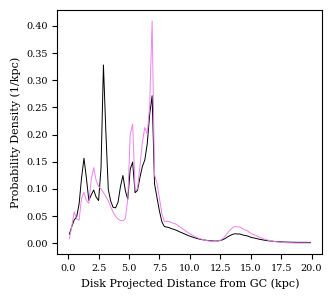

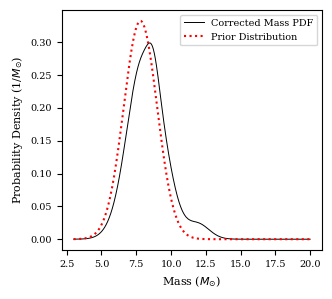

In [2]:
# Create Overall GC Plots
# -----------------------------
if global_gc_hist is not None and global_gc_count > 0:
    # Average the global GC histogram over the number of sources.
    global_gc_hist_avg = global_gc_hist / global_gc_count
    global_maxi_xrt_gc_hist_avg = global_maxi_xrt_gc_hist/global_gc_maxi_xrt_count

    # Use the common GC bins and the stored mass bins.
    gc_midpoints = gc_bins[:-1] + 0.5 * (gc_bins[1]-gc_bins[0])
    if global_masses_bins is not None:
        mass_midpoints = global_masses_bins[:-1] + 0.5 * (global_masses_bins[1]-global_masses_bins[0])
    else:
        mass_midpoints = np.arange(global_gc_hist_avg.shape[0])

    # Marginalize to get overall GC distance and mass PDFs.
    # For GC distance PDF, integrate (sum) over the mass axis.
    global_gc_distance_pdf = np.sum(global_gc_hist_avg, axis=0) * (global_masses_bins[1]-global_masses_bins[0])
    global_gc_maxi_xrt_distance_pdf = np.sum(global_maxi_xrt_gc_hist_avg, axis=0) * (global_masses_bins[1]-global_masses_bins[0])

    # For mass PDF, integrate over the GC distance axis.
    gc_bin_width = gc_bins[1]-gc_bins[0]
    global_mass_pdf = np.sum(global_gc_hist_avg, axis=1) * gc_bin_width


    # --- Set matplotlib rc parameters ---
    plt.rc('font', family='Serif', size=7)
    plt.rc('axes', titlesize=7, labelsize=8)
    plt.rc('xtick', labelsize=7)
    plt.rc('ytick', labelsize=7)
    plt.rc('legend', fontsize=7)
    plt.rc('figure', titlesize=9)

    # Plotting.
    plt.figure(figsize=(10/3, 3))
    plt.plot(gc_midpoints, global_gc_distance_pdf, color='black',linewidth=0.7)
    plt.plot(gc_midpoints, global_gc_maxi_xrt_distance_pdf, color='violet',linewidth=0.7)
    plt.xlabel('Disk Projected Distance from GC (kpc)')
    plt.ylabel('Probability Density (1/kpc)')
    # plt.title('Overall Galactocentric Distance Distribution')
    # plt.legend()
    plt.tight_layout()
    plt.savefig('plots/overall_gc_distance_distribution_corrected.pdf')
    plt.show()
    
    plt.figure(figsize=(10/3, 3))
    plt.plot(mass_midpoints, global_mass_pdf[:-1], label='Corrected Mass PDF', color='black',linewidth=0.7)
    plt.plot(np.append(masses_bins,masses_bins[-1]+mass_step),norm.pdf(np.append(masses_bins,masses_bins[-1]+mass_step),loc=7.8,scale=1.2),'r:',label='Prior Distribution')
    plt.xlabel(r'Mass ($M_{\odot}$)')
    plt.ylabel(r'Probability Density (1/$M_{\odot}$)')
    # plt.title('Overall Mass Distribution')
    plt.legend()
    plt.tight_layout()
    plt.savefig('plots/overall_mass_distribution_corrected.pdf')
    plt.show()
else:
    print("No valid global GC histogram was accumulated; no overall plot generated.")


In [13]:
len(gc_midpoints)

100

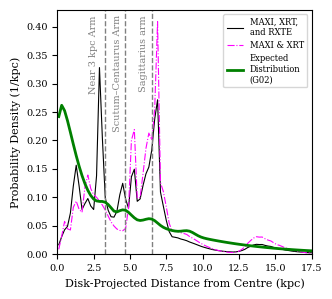

2.9000000000000004


In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters from GR02 (typical values)
# Bulge parameters
q = 0.6       # axis ratio
r0 = 1     # scale radius [kpc]
rt = 1.9      # truncation radius [kpc]
gamma = 1.8   # power-law index

# Disc parameters
rm = 6.5      # central hole radius [kpc]
rd = 3.5      # radial scale length [kpc]
rz = 0.41     # vertical scale height [kpc]

# Spheroid parameters
Re = 2.8      # effective radius [kpc]
b = 7.669     # shape parameter

# Normalization constants from paper
rho0_bulge = 1.19 *(10**9)    # M☉/pc³
rho0_disc = 2.79 *(10**9)   # M☉/pc³
rho0_sphere = 22.38 *(10**9)   # M☉/pc³

# Normalization constants from paper
rho0_bulge = 1.1 *(10**9)    # M☉/pc³
rho0_disc = 2.6 *(10**9)   # M☉/pc³
rho0_sphere = 13.1 *(10**9)   # M☉/pc³

# Spiral arm parameters
w_a = 0.6               # width of spiral arm in kpc (600 pc)
pitch = np.deg2rad(12)  # pitch angle in radians (~12°)
phi0_list = np.array([0, np.pi/2, np.pi, 3*np.pi/2])
# phi0_list = np.array([0.26, 1.14, 3.40, 4.28])
r_ref = rm  # reference radius for spiral arms


# ---------------------------------------------------------------------
# Define separate density functions for each component:
# ---------------------------------------------------------------------

def spiral_modulation(r, phi):
    """
    Computes the modulation factor due to spiral arms at a given (r, phi).
    Assumes a logarithmic spiral for each arm and returns a Gaussian
    factor based on the minimum distance from the spiral arms.
    """
    s_list = []
    for phi0 in phi0_list:
        # Logarithmic spiral: r_arm = r_ref * exp((phi - phi0)*tan(pitch))
        r_arm = r_ref * np.exp((phi - phi0) * np.tan(pitch))
        s_list.append(np.abs(r - r_arm))
    s_min = np.min(s_list)
    return np.exp(-(s_min / w_a)**2)

def density_bulge(r, z=0):
    """
    Bulge density in cylindrical coordinates.
    Computes an 'elliptical' radius: R_ell = sqrt(r^2 + (z/q)^2).
    """
    R_ell = np.sqrt(r**2 + (z/q)**2)
    return rho0_bulge * (R_ell/r0)**(-gamma) * np.exp(-(r**2 + (z/q)**2) / rt**2)

def density_disc(r, z=0):
    """
    Disc density in cylindrical coordinates.
    At z=0 (and rm=0), this becomes: rho0_disc * exp(-r/rd)
    """
    return rho0_disc * np.exp(- (rm/rd + r/rd + np.abs(z)/rz))

def density_spheroid(r, z=0):
    """
    Spheroid density (assumed spherically symmetric).
    Uses the spherical radius: R = sqrt(r^2 + z^2).
    At z=0, R = r.
    """
    R = np.sqrt(r**2 + z**2)
    # Avoid division by zero: if R == 0, substitute a small epsilon.
    epsilon = 1e-10
    R_safe = np.where(R == 0, epsilon, R)
    return rho0_sphere * np.exp(-b*(R_safe/Re)**0.25) / (R_safe/Re)**(7/8)

def total_density(x, y, z=0):
    """
    Combined density evaluated at (x, y, z) using all three components.
    x and y are used to compute the cylindrical radius r.
    """
    r = np.sqrt(x**2 + y**2)
    return density_bulge(r, z) + density_disc(r, z) + density_spheroid(r, z)

# ---------------------------------------------------------------------
# Visualization: 2D Density Map in the Galactic Plane (z=0)
# ---------------------------------------------------------------------

# # Create grid in the Galactic plane (z=0)
# x = np.linspace(-15, 15, 200)  # kpc
# y = np.linspace(-15, 15, 200)  # kpc
# X, Y = np.meshgrid(x, y)

# # Calculate densities on the 2D grid (z=0)
# Z = total_density(X, Y)

# plt.figure(figsize=(12, 5))
# plt.subplot(121)
# plt.pcolormesh(X, Y, np.log10(Z + 1e-6), cmap='viridis', shading='auto')
# plt.colorbar(label='log$_{10}$(ρ [M☉/pc³])')
# plt.xlabel('x [kpc]')
# plt.ylabel('y [kpc]')
# plt.title('Total Density in Galactic Plane (z=0)')

# ---------------------------------------------------------------------
# Compute Radial Profile Integrated Over z from -5 kpc to 5 kpc
# ---------------------------------------------------------------------

# Define radial and vertical (z) grids
r_profile = gc_midpoints # kpc
z_vals = np.linspace(-5, 5, 1000)       # kpc
# Fix phi to the Sun's direction (φ = π/2)
phi_sun = np.pi / 2  

# Compute the integrated density (surface density) for each r:
Sigma_profile = np.zeros_like(r_profile)
for i, r in enumerate(r_profile):
    # Evaluate the total density at fixed r (with y=0) over the z range
    # Note: total_density(r, 0, z_vals) returns an array (because z_vals is an array)

    mod_factor = 1 + 0.2 * spiral_modulation(r, phi_sun)

    density_z = total_density(r, 0, z=z_vals) * mod_factor
    # Integrate density over z to obtain the surface density at radius r:
    Sigma_profile[i] = np.trapz(density_z, z_vals)

# Now, convert this integrated density into a radial probability density.
# The cylindrical area element is dA = 2πr dr.
unnorm_pdf =  Sigma_profile*(2 * np.pi * r_profile)

# Normalize the PDF so that its integral is 1:
norm_constant = np.trapz(unnorm_pdf, r_profile)
pdf_radial_normalized = unnorm_pdf / norm_constant

# ---------------------------------------------------------------------
# Plot the Normalized Radial PDF (Integrated Over z)
# ---------------------------------------------------------------------

# --- Set matplotlib rc parameters ---
plt.rc('font', family='Serif', size=7)
plt.rc('axes', titlesize=7, labelsize=8)
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.rc('legend', fontsize=6)
plt.rc('figure', titlesize=9)

# Plotting.
plt.figure(figsize=(10/3, 3))
plt.plot(gc_midpoints, global_gc_distance_pdf, color='black',linewidth=0.8,label='MAXI, XRT,\nand RXTE')
plt.plot(gc_midpoints, global_gc_maxi_xrt_distance_pdf, color='magenta',linestyle='-.',linewidth=0.8,label='MAXI & XRT')
for x_val, text_label in zip([3.3, 4.65, 6.5], ['Near 3 kpc Arm', 'Scutum–Centaurus Arm', 'Sagittarius arm']):
    plt.axvline(x=x_val, color='gray', linestyle='--', lw=1)
    # Place the text slightly to the right of the line.
    if x_val == 6.5:        
        plt.text(x_val - 0.9, 0.42, text_label,
                rotation=90, fontsize=7, color='gray', va='top')
    elif x_val == 4.65:
        plt.text(x_val - 0.8, 0.42, text_label,
                rotation=90, fontsize=7, color='gray', va='top')
    else:
        plt.text(x_val - 1.1, 0.42, text_label,
                rotation=90, fontsize=7, color='gray', va='top')
plt.xlabel('Disk-Projected Distance from Centre (kpc)')
plt.ylabel('Probability Density (1/kpc)')
plt.xlim([0,17.5])
plt.ylim(bottom=0)
# plt.title('Overall Galactocentric Distance Distribution')
# plt.legend()
plt.plot(r_profile, pdf_radial_normalized, 'g-', lw=2, label='Expected\nDistribution\n(G02)')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.savefig('plots/overall_gc_distance_distribution_corrected.pdf')
plt.show()

print(gc_midpoints[np.argmax(global_gc_distance_pdf)])

------ Without RXTE ------
Total number of sources: 13
Maximum |z|: 3522.74, Minimum |z|: 30.14
Minimum z: -3522.74, Maximum z: 547.76
RMS (no bootstrap) = 1062.87 pc
RMS (bootstrap) = 969.53 +/- 447.09 pc
------ With RXTE ------
Total number of sources: 26
Maximum |z|: 3522.74, Minimum |z|: 30.14
Minimum z: -3522.74, Maximum z: 1963.84
RMS (no bootstrap) = 907.09 pc
RMS (bootstrap) = 864.43 +/- 267.41 pc


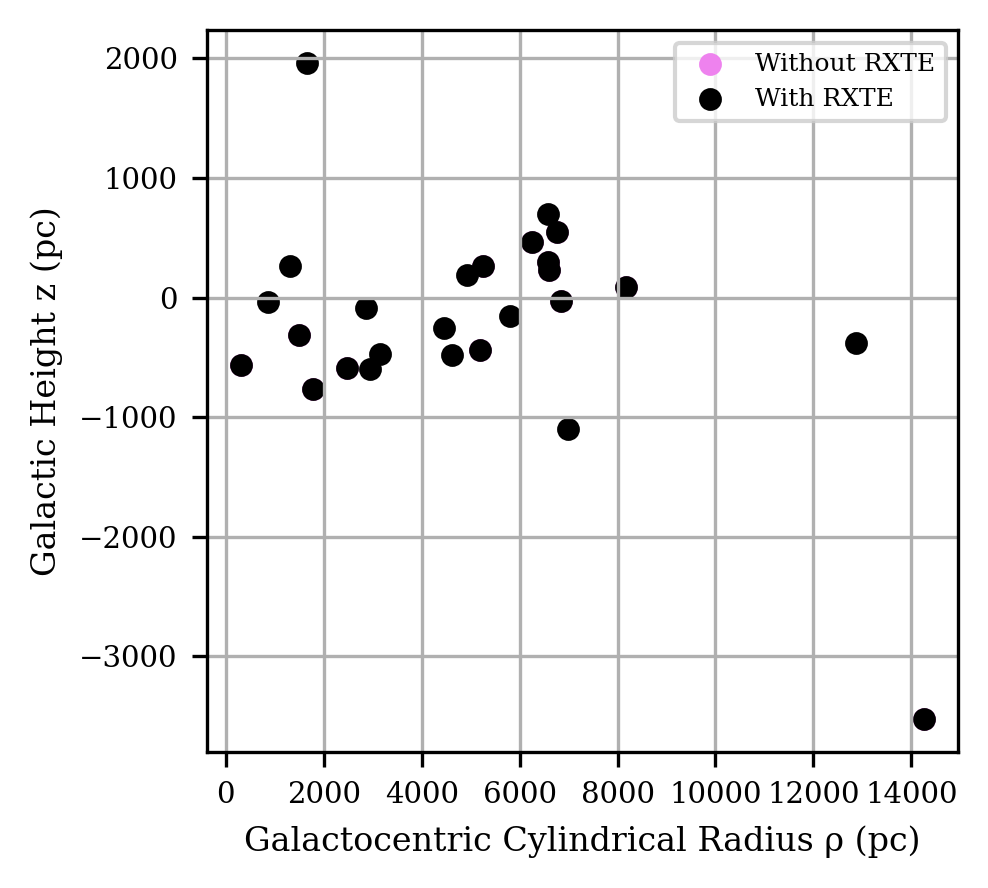

In [102]:
#!/usr/bin/env python
"""
This script reads the CSV file 'source_distance_mass_results_with_coords.csv' produced
by the previous code, which now contains RA, Dec, and median_distance (in kiloparsecs).
It converts these values into ICRS SkyCoord objects, transforms them to Galactocentric
coordinates, and extracts the vertical height (z) and cylindrical radius (ρ) for each source.
Summary statistics (including RMS and bootstrap-based uncertainty estimates) are printed,
and a scatter plot of ρ versus z is produced.

Reputable sources and documentation:
- Pandas: https://pandas.pydata.org/pandas-docs/stable/
- Astropy Coordinates: https://docs.astropy.org/en/stable/coordinates/
- Astropy Units: https://docs.astropy.org/en/stable/units/
- NumPy: https://numpy.org/doc/
- Matplotlib: https://matplotlib.org/
- MNRAS Author Guidelines: https://academic.oup.com/mnras/pages/General_Instructions
- Bootstrap Resampling (Efron & Tibshirani, 1993): https://en.wikipedia.org/wiki/Bootstrapping_(statistics)
- SciPy Bootstrap Example: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html
"""

import pandas as pd
import numpy as np
from astropy import units as u
import astropy.coordinates as apycoords
import matplotlib.pyplot as plt
import matplotlib as mpl

def bootstrap_rms(z_values, n_bootstrap=10000, random_seed=42):
    """
    Estimate the RMS of z_values and its uncertainty using bootstrap resampling.

    Parameters
    ----------
    z_values : ndarray
        Array of z-values for which to compute the RMS.
    n_bootstrap : int
        Number of bootstrap samples to draw.
    random_seed : int
        Seed for the random number generator for reproducibility.

    Returns
    -------
    rms_mean : float
        Mean of the bootstrapped RMS values.
    rms_std : float
        Standard deviation (uncertainty) of the bootstrapped RMS values.
    """
    rng = np.random.default_rng(random_seed)
    N = len(z_values)
    rms_samples = np.zeros(n_bootstrap)
    
    for i in range(n_bootstrap):
        sample = rng.choice(z_values, size=N, replace=True)
        rms_samples[i] = np.sqrt(np.mean(sample**2))
    
    # The bootstrap estimate of RMS can be taken as the mean of all RMS samples
    rms_mean = np.mean(rms_samples)
    rms_std = np.std(rms_samples)
    return rms_mean, rms_std


# --- Read the CSV file ---
csv_file = 'source_distance_mass_results_with_coords.csv'
df = pd.read_csv(csv_file)

# --- Ensure numeric columns are properly cast ---
df['ra'] = pd.to_numeric(df['ra'], errors='coerce')
df['dec'] = pd.to_numeric(df['dec'], errors='coerce')
df['median_distance'] = pd.to_numeric(df['median_distance'], errors='coerce')

df_rxte = df
df = df[df['instrument'] != 'RXTE_PCA']

# --- Convert median_distance from kiloparsecs to parsecs ---
distance_pc = df['median_distance'].values * 1000 * u.pc
ra = df['ra'].values * u.deg
dec = df['dec'].values * u.deg

distance_pc_rxte = df_rxte['median_distance'].values * 1000 * u.pc
ra_rxte = df_rxte['ra'].values * u.deg
dec_rxte = df_rxte['dec'].values * u.deg

# --- Create ICRS SkyCoord object ---
coord_icrs = apycoords.SkyCoord(ra=ra, dec=dec, distance=distance_pc, frame='icrs')
coord_icrs_rxte = apycoords.SkyCoord(ra=ra_rxte, dec=dec_rxte, distance=distance_pc_rxte, frame='icrs') 

# --- Transform to Galactocentric coordinates ---
coord_gal = coord_icrs.transform_to(apycoords.Galactocentric())
coord_gal_rxte = coord_icrs_rxte.transform_to(apycoords.Galactocentric())

# --- Extract vertical height (z) and cylindrical radius (ρ) ---
z = coord_gal.cartesian.z  # z coordinate in pc
rho = coord_gal.cylindrical.rho  # cylindrical radius in pc

z_rxte = coord_gal_rxte.cartesian.z
rho_rxte = coord_gal_rxte.cylindrical.rho

# Convert z to a NumPy array in pc (float) for convenience in RMS calculations
z_arr = z.value
z_arr_rxte = z_rxte.value

# --- Print summary statistics (without RXTE) ---
print("------ Without RXTE ------")
print(f"Total number of sources: {len(df)}")
print(f"Maximum |z|: {np.max(np.abs(z_arr)):.2f}, Minimum |z|: {np.min(np.abs(z_arr)):.2f}")
print(f"Minimum z: {np.min(z_arr):.2f}, Maximum z: {np.max(z_arr):.2f}")

# Standard RMS
rms_no_rxte = np.sqrt(np.mean(z_arr**2))
print(f"RMS (no bootstrap) = {rms_no_rxte:.2f} pc")

# Bootstrap RMS
rms_mean_no_rxte, rms_std_no_rxte = bootstrap_rms(z_arr, n_bootstrap=10000)
print(f"RMS (bootstrap) = {rms_mean_no_rxte:.2f} +/- {rms_std_no_rxte:.2f} pc")

# --- Print summary statistics (with RXTE) ---
print("------ With RXTE ------")
print(f"Total number of sources: {len(df_rxte)}")
print(f"Maximum |z|: {np.max(np.abs(z_arr_rxte)):.2f}, Minimum |z|: {np.min(np.abs(z_arr_rxte)):.2f}")
print(f"Minimum z: {np.min(z_arr_rxte):.2f}, Maximum z: {np.max(z_arr_rxte):.2f}")

# Standard RMS
rms_rxte = np.sqrt(np.mean(z_arr_rxte**2))
print(f"RMS (no bootstrap) = {rms_rxte:.2f} pc")

# Bootstrap RMS
rms_mean_rxte, rms_std_rxte = bootstrap_rms(z_arr_rxte, n_bootstrap=10000)
print(f"RMS (bootstrap) = {rms_mean_rxte:.2f} +/- {rms_std_rxte:.2f} pc")

# --- Set up Matplotlib for publication-quality figures ---
mpl.rcParams['font.size'] = 8         # Base font size
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif']
mpl.rcParams['axes.titlesize'] = 8    # Title font size
mpl.rcParams['axes.labelsize'] = 8    # Axis labels font size
mpl.rcParams['xtick.labelsize'] = 7   # X tick labels font size
mpl.rcParams['ytick.labelsize'] = 7   # Y tick labels font size
mpl.rcParams['figure.dpi'] = 300      # High resolution for publication

# MNRAS one-column width is typically ~8.5 cm (3.35 inches)
plt.figure(figsize=(10/3, 3))

plt.scatter(rho.value, z_arr, s=20, color='violet', alpha=1, label='Without RXTE')
plt.scatter(rho_rxte.value, z_arr_rxte, s=20, color='black', alpha=1, label='With RXTE')
plt.xlabel("Galactocentric Cylindrical Radius ρ (pc)")
plt.ylabel("Galactic Height z (pc)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


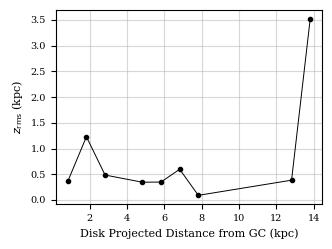

In [17]:
#!/usr/bin/env python
"""
Script to:
1. Read a CSV containing RA, Dec, median_distance (in kiloparsecs), etc.
2. Convert those coordinates to Galactocentric (z, rho).
3. Compute the RMS of z in radial bins of rho for the *entire* dataset (including RXTE).
4. Plot RMS(z) vs. rho with bootstrap-based uncertainties.

Reputable sources and documentation:
- Pandas: https://pandas.pydata.org/pandas-docs/stable/
- Astropy Coordinates: https://docs.astropy.org/en/stable/coordinates/
- Astropy Units: https://docs.astropy.org/en/stable/units/
- NumPy: https://numpy.org/doc/
- Matplotlib: https://matplotlib.org/
- Bootstrap Resampling (Efron & Tibshirani, 1993): https://en.wikipedia.org/wiki/Bootstrapping_(statistics)
- SciPy Bootstrap Example: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html
"""

import pandas as pd
import numpy as np
from astropy import units as u
import astropy.coordinates as apycoords
import matplotlib.pyplot as plt
import matplotlib as mpl

def bootstrap_rms(z_values, n_bootstrap=1000, random_seed=42):
    """
    Estimate the RMS of z_values and its uncertainty using bootstrap resampling.

    Parameters
    ----------
    z_values : ndarray
        Array of z-values for which to compute the RMS.
    n_bootstrap : int
        Number of bootstrap samples to draw.
    random_seed : int
        Seed for the random number generator for reproducibility.

    Returns
    -------
    rms_mean : float
        Mean of the bootstrapped RMS values.
    rms_std : float
        Standard deviation (uncertainty) of the bootstrapped RMS values.
    """
    rng = np.random.default_rng(random_seed)
    N = len(z_values)
    rms_samples = np.zeros(n_bootstrap)
    
    for i in range(n_bootstrap):
        sample = rng.choice(z_values, size=N, replace=True)
        rms_samples[i] = np.sqrt(np.mean(sample**2))
    
    return np.mean(rms_samples), np.std(rms_samples)

def transform_to_galactocentric(df_input):
    """
    Transform RA, Dec, median_distance (kpc) to Galactocentric coords.
    Returns arrays of z and rho in pc.
    """
    # Convert distance from kpc to pc
    distance_pc = df_input['median_distance'].values * 1000 * u.pc
    ra = df_input['ra'].values * u.deg
    dec = df_input['dec'].values * u.deg
    
    # Create SkyCoord in ICRS and transform to Galactocentric
    coord_icrs = apycoords.SkyCoord(ra=ra, dec=dec, distance=distance_pc, frame='icrs')
    coord_gal = coord_icrs.transform_to(apycoords.Galactocentric())
    
    # Extract z (vertical) and rho (cylindrical radius), in pc
    z_vals = coord_gal.cartesian.z.value
    rho_vals = coord_gal.cylindrical.rho.value
    return z_vals, rho_vals

def compute_binned_rms(z_array, rho_array, nbins=10):
    """
    Bin the data in rho, compute the RMS of z in each bin,
    along with bootstrap-based uncertainties.

    Parameters
    ----------
    z_array : ndarray
        Array of z-values.
    rho_array : ndarray
        Array of corresponding rho-values.
    nbins : int
        Number of bins in rho.

    Returns
    -------
    bin_centers : ndarray
        The center of each rho bin.
    rms_values : ndarray
        RMS of z in each bin (bootstrap mean).
    rms_errs : ndarray
        Bootstrap uncertainty on the RMS in each bin.
    """
    rho_min, rho_max = rho_array.min(), rho_array.max()
    bins = np.arange(rho_min, rho_max+1000, 1000)
    
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    rms_values = []
    rms_errs = []
    
    for i in range(len(bins)-1):
        in_bin = (rho_array >= bins[i]) & (rho_array < bins[i+1])
        z_in_bin = z_array[in_bin]
        
        if len(z_in_bin) == 0:
            rms_values.append(0)
            rms_errs.append(0)
            continue
        
        # # Compute the bootstrap RMS for this bin
        # rms_mean, rms_std = bootstrap_rms(z_in_bin, n_bootstrap=1000, random_seed=42)
        rms_mean = np.sqrt(np.mean(z_in_bin**2))
        rms_values.append(rms_mean)
        # rms_errs.append(rms_std)
    
    return np.array(bin_centers), np.array(rms_values)

# =============== Read data ===============
csv_file = 'source_distance_mass_results_with_coords.csv'
df = pd.read_csv(csv_file)

# Ensure columns are numeric
df['ra'] = pd.to_numeric(df['ra'], errors='coerce')
df['dec'] = pd.to_numeric(df['dec'], errors='coerce')
df['median_distance'] = pd.to_numeric(df['median_distance'], errors='coerce')

# Here, we do NOT filter out RXTE, so df contains everything:
# df = df[df['instrument'] != 'RXTE_PCA']  # <-- We do NOT do this

# =============== Transform coords ===============
z_arr, rho_arr = transform_to_galactocentric(df)

z_arr = z_arr[np.argsort(rho_arr)]
rho_arr = rho_arr[np.argsort(rho_arr)]

# =============== Binned RMS ===============
bin_centers, rms_values = compute_binned_rms(z_arr, rho_arr)

# =============== Plot ===============
# Set Matplotlib for publication-quality figures
# mpl.rcParams['font.size'] = 8
# mpl.rcParams['font.family'] = 'serif'
# mpl.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif']
# mpl.rcParams['axes.titlesize'] = 8
# mpl.rcParams['axes.labelsize'] = 8
# mpl.rcParams['xtick.labelsize'] = 7
# mpl.rcParams['ytick.labelsize'] = 7
# mpl.rcParams['figure.dpi'] = 300

# --- Set matplotlib rc parameters ---
plt.rc('font', family='Serif', size=7)
plt.rc('axes', titlesize=7, labelsize=8)
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.rc('legend', fontsize=6)
plt.rc('figure', titlesize=9)

plt.figure(figsize=(10/3, 2.5))

bin_centers = bin_centers[rms_values > 0]/1000
rms_values = rms_values[rms_values > 0]/1000


# plt.errorbar(
#     bin_centers,
#     rms_values,
#     fmt='o-',
#     color='black',
#     ecolor='black',
#     capsize=3
# )

plt.plot(bin_centers,rms_values,color='black',marker='o',markersize=3,linewidth=0.7)
plt.xlabel('Disk Projected Distance from GC (kpc)')
plt.ylabel(r'$z_{\text{rms}}$ (kpc)')
plt.grid(True,alpha=0.5)
# plt.legend()
plt.tight_layout()
plt.savefig('plots/z_rms_r_profile.pdf', bbox_inches = 'tight')
plt.show()


In [31]:
#!/usr/bin/env python
"""
This script loads the CSV file 'source_distance_mass_results_with_coords.csv' (which now 
includes RA, Dec, median_distance, lower_distance_error, and upper_distance_error), converts 
the coordinates to Astropy SkyCoord objects in ICRS, transforms them into Galactocentric 
coordinates, and then extracts the vertical height (z) and cylindrical radius (rho) along with 
error estimates. Finally, it produces a scatter plot with error bars.

Reputable sources and documentation:
- Pandas: https://pandas.pydata.org/pandas-docs/stable/
- Astropy Coordinates: https://docs.astropy.org/en/stable/coordinates/
- Astropy Units: https://docs.astropy.org/en/stable/units/
- Matplotlib: https://matplotlib.org/
- NumPy: https://numpy.org/doc/
"""

import pandas as pd
import numpy as np
from astropy import units as u
import astropy.coordinates as apycoords
import matplotlib.pyplot as plt

# --- Set matplotlib rc parameters ---
plt.rc('font', family='Serif', size=7)
plt.rc('axes', titlesize=7, labelsize=8)
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.rc('legend', fontsize=7)
plt.rc('figure', titlesize=9)

# --- Load the CSV file ---
csv_file = 'source_distance_mass_results_with_coords.csv'
df = pd.read_csv(csv_file)
# df = df[df['instrument'] == 'RXTE_PCA']

# --- Convert necessary columns to numeric (assume distances are in kiloparsecs) ---
df['ra'] = pd.to_numeric(df['ra'], errors='coerce')
df['dec'] = pd.to_numeric(df['dec'], errors='coerce')
df['median_distance'] = pd.to_numeric(df['median_distance'], errors='coerce')
df['lower_distance_error'] = pd.to_numeric(df['lower_distance_error'], errors='coerce')
df['upper_distance_error'] = pd.to_numeric(df['upper_distance_error'], errors='coerce')

# --- Convert distances from kiloparsecs to parsecs ---
median_dist_pc = df['median_distance'].values * 1000 * u.pc
lower_bound_pc = (df['median_distance'] - df['lower_distance_error']).values * 1000 * u.pc
upper_bound_pc = (df['median_distance'] + df['upper_distance_error']).values * 1000 * u.pc

# --- Create ICRS SkyCoord objects for median, lower, and upper distances ---
c_med = apycoords.SkyCoord(ra=df['ra'].values * u.deg,
                           dec=df['dec'].values * u.deg,
                           distance=median_dist_pc,
                           frame='icrs')
c_lower = apycoords.SkyCoord(ra=df['ra'].values * u.deg,
                             dec=df['dec'].values * u.deg,
                             distance=lower_bound_pc,
                             frame='icrs')
c_upper = apycoords.SkyCoord(ra=df['ra'].values * u.deg,
                             dec=df['dec'].values * u.deg,
                             distance=upper_bound_pc,
                             frame='icrs')

# --- Transform to Galactocentric coordinates ---
gc_med = c_med.transform_to(apycoords.Galactocentric())
gc_lower = c_lower.transform_to(apycoords.Galactocentric())
gc_upper = c_upper.transform_to(apycoords.Galactocentric())

# --- Extract vertical coordinate (z) from the median ---
z_all = np.abs(gc_med.cartesian.z.value)  # in pc

# --- Convert Galactocentric coordinates to cylindrical representations ---
cyl_med   = gc_med.represent_as(apycoords.CylindricalRepresentation)
cyl_lower = gc_lower.represent_as(apycoords.CylindricalRepresentation)
cyl_upper = gc_upper.represent_as(apycoords.CylindricalRepresentation)

# Median cylindrical radius (always non-negative)
rho_all = cyl_med.rho.value     # in pc

# --- Compute error bars from lower and upper bounds for z ---
# (Taking absolute differences so that errors are nonnegative)
z_lower_err = np.abs(np.abs(gc_med.cartesian.z.value) - np.abs(gc_lower.cartesian.z.value))
z_upper_err = np.abs(np.abs(gc_upper.cartesian.z.value) - np.abs(gc_med.cartesian.z.value))

# --- Compute error bars for cylindrical radius (rho) ---
# Compute raw (absolute) differences first:
raw_rho_lower_err = np.abs(rho_all - cyl_lower.rho.value)
raw_rho_upper_err = np.abs(cyl_upper.rho.value - rho_all)

# Ensure that subtracting the lower error does not lead to a negative rho:
rho_lower_err = np.minimum(raw_rho_lower_err, rho_all)
rho_upper_err = raw_rho_upper_err

###### NO RXTE ######

df_no_rxte = pd.read_csv(csv_file)
df_no_rxte = df_no_rxte[df_no_rxte['instrument'] != 'RXTE_PCA']

# --- Convert necessary columns to numeric (assume distances are in kiloparsecs) ---
df_no_rxte['ra'] = pd.to_numeric(df_no_rxte['ra'], errors='coerce')
df_no_rxte['dec'] = pd.to_numeric(df_no_rxte['dec'], errors='coerce')
df_no_rxte['median_distance'] = pd.to_numeric(df_no_rxte['median_distance'], errors='coerce')
df_no_rxte['lower_distance_error'] = pd.to_numeric(df_no_rxte['lower_distance_error'], errors='coerce')
df_no_rxte['upper_distance_error'] = pd.to_numeric(df_no_rxte['upper_distance_error'], errors='coerce')

# --- Convert distances from kiloparsecs to parsecs ---
median_dist_pc = df_no_rxte['median_distance'].values * 1000 * u.pc
lower_bound_pc = (df_no_rxte['median_distance'] - df_no_rxte['lower_distance_error']).values * 1000 * u.pc
upper_bound_pc = (df_no_rxte['median_distance'] + df_no_rxte['upper_distance_error']).values * 1000 * u.pc

# --- Create ICRS SkyCoord objects for median, lower, and upper distances ---
c_med = apycoords.SkyCoord(ra=df_no_rxte['ra'].values * u.deg,
                           dec=df_no_rxte['dec'].values * u.deg,
                           distance=median_dist_pc,
                           frame='icrs')
c_lower = apycoords.SkyCoord(ra=df_no_rxte['ra'].values * u.deg,
                             dec=df_no_rxte['dec'].values * u.deg,
                             distance=lower_bound_pc,
                             frame='icrs')
c_upper = apycoords.SkyCoord(ra=df_no_rxte['ra'].values * u.deg,
                             dec=df_no_rxte['dec'].values * u.deg,
                             distance=upper_bound_pc,
                             frame='icrs')

# --- Transform to Galactocentric coordinates ---
gc_med = c_med.transform_to(apycoords.Galactocentric())
gc_lower = c_lower.transform_to(apycoords.Galactocentric())
gc_upper = c_upper.transform_to(apycoords.Galactocentric())

# --- Extract vertical coordinate (z) from the median ---
z_all_no_rxte = np.abs(gc_med.cartesian.z.value)  # in pc

# --- Convert Galactocentric coordinates to cylindrical representations ---
cyl_med   = gc_med.represent_as(apycoords.CylindricalRepresentation)
cyl_lower = gc_lower.represent_as(apycoords.CylindricalRepresentation)
cyl_upper = gc_upper.represent_as(apycoords.CylindricalRepresentation)

# Median cylindrical radius (always non-negative)
rho_all_no_rxte = cyl_med.rho.value     # in pc

# --- Compute error bars from lower and upper bounds for z ---
# (Taking absolute differences so that errors are nonnegative)
z_lower_err_no_rxte = np.abs(np.abs(gc_med.cartesian.z.value) - np.abs(gc_lower.cartesian.z.value))
z_upper_err_no_rxte = np.abs(np.abs(gc_upper.cartesian.z.value) - np.abs(gc_med.cartesian.z.value))

# --- Compute error bars for cylindrical radius (rho) ---
# Compute raw (absolute) differences first:
raw_rho_lower_err = np.abs(rho_all_no_rxte - cyl_lower.rho.value)
raw_rho_upper_err = np.abs(cyl_upper.rho.value - rho_all_no_rxte)

# Ensure that subtracting the lower error does not lead to a negative rho:
rho_lower_err_no_rxte = np.minimum(raw_rho_lower_err, rho_all_no_rxte)
rho_upper_err_no_rxte = raw_rho_upper_err


[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4
 3.6]


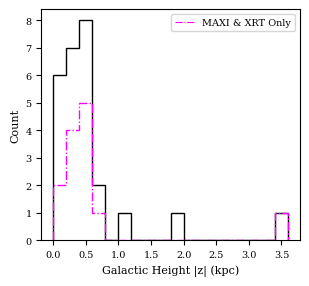

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


fig = plt.figure(num=1, clear=True, figsize=(10/3, 3))
max_val = 3.5
binWidth = 0.2
bins = np.arange(0, max_val + binWidth, binWidth)
print(bins)

# Plot the histograms
plt.hist(np.abs(z_all)/1000, bins=bins, color='black', histtype='step', fill=False)
plt.hist(np.abs(z_all_no_rxte)/1000, bins=bins, color='magenta', linestyle='-.', 
         histtype='step', fill=False, label='MAXI & XRT Only')

plt.xlabel('Galactic Height |z| (kpc)')
plt.ylabel("Count")

# Create a custom legend handle using Line2D for the dashed-dotted line
custom_line = Line2D([0], [0], color='magenta', lw=0.8, linestyle='-.', 
                     label='MAXI & XRT Only')

# Use the custom handle in the legend
plt.legend(handles=[custom_line])

plt.savefig('plots/galactic_heights.pdf', format='pdf', bbox_inches='tight')
plt.show()


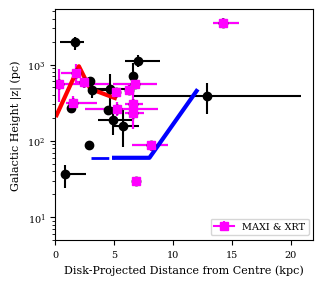

In [37]:
fig = plt.figure(num=2, figsize=(10/3, 3))
for j in range(len(z_all)):
    plt.errorbar(rho_all[j]/1000, z_all[j],
                 xerr=[[rho_lower_err[j]/1000], [rho_upper_err[j]/1000]],
                 yerr=[[z_lower_err[j]], [z_upper_err[j]]],
                 fmt='ko')
for j in range(len(z_all_no_rxte)):
    plt.errorbar(rho_all_no_rxte[j]/1000, z_all_no_rxte[j],
                xerr=[[rho_lower_err_no_rxte[j]/1000], [rho_upper_err_no_rxte[j]/1000]],
                yerr=[[z_lower_err_no_rxte[j]], [z_upper_err_no_rxte[j]]],
                color='magenta',marker='s',markersize = 6,label='MAXI & XRT')
                 
plt.yscale('log')
plt.xlim(xmin=0)    
plt.ylim(ymin=5)
plt.ylabel('Galactic Height |z| (pc)')
plt.xlabel('Disk-Projected Distance from Centre (kpc)')

# Example reference lines (customize as needed)
plt.plot([3, 5], [60, 60], 'b-.', linewidth=2)
plt.plot([5, 8, 12], [60, 60, 450], color='blue', linewidth=3)
plt.plot([0.120, 2.016, 2.970, 5.067], [217, 948, 481, 364], 'red', linewidth=3)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),loc='lower right')
plt.savefig('plots/galactic_heights_vs_rho.pdf', format='pdf', bbox_inches='tight')
plt.show()


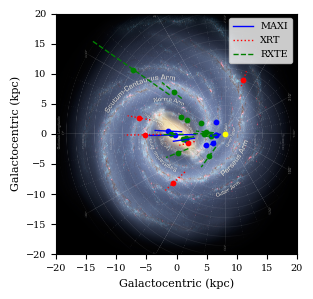

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.coordinates as apycoords
from mw_plot import MWFaceOn  # See https://milkyway-plot.readthedocs.io/

# --- Load CSV and ensure proper numeric conversion ---
csv_file = 'source_distance_mass_results_with_coords.csv'
df = pd.read_csv(csv_file)

# Convert the relevant columns to numeric
df['ra'] = pd.to_numeric(df['ra'], errors='coerce')
df['dec'] = pd.to_numeric(df['dec'], errors='coerce')
df['median_distance'] = pd.to_numeric(df['median_distance'], errors='coerce')
df['lower_distance_error'] = pd.to_numeric(df['lower_distance_error'], errors='coerce')
df['upper_distance_error'] = pd.to_numeric(df['upper_distance_error'], errors='coerce')

# --- Optionally, split the DataFrame by instrument ---
if 'instrument' in df.columns:
    df_maxi = df[df['instrument'] == 'MAXI']
    df_xrt  = df[df['instrument'] == 'XRT']
    df_rxte = df[df['instrument'] == 'RXTE_PCA']
else:
    df_maxi = df.copy()
    df_xrt = pd.DataFrame()
    df_rxte = pd.DataFrame()

def plot_distance_error(df_subset, color, label, linestyle):
    """
    For each source in the DataFrame subset, this function:
      - Computes the lower-bound position using (median_distance - lower_distance_error)
      - Computes the upper-bound position using (median_distance + upper_distance_error)
      - Computes the median position using median_distance
    It then transforms these into Galactocentric coordinates and plots:
      - A line (error bar) connecting the lower and upper positions (with the label)
      - A marker at the median position (without the label)
    
    Parameters
    ----------
    df_subset : pandas.DataFrame
        Must contain 'ra', 'dec', 'median_distance', 'lower_distance_error', and 'upper_distance_error' columns.
    color : str
        The color for both the error line and the marker.
    label : str
        The legend label (only applied for the first plotted line of this subset).
    linestyle : str
        The line style (e.g., '-', ':', '--') for the error bar.
    """
    # Create SkyCoord objects for lower, median, and upper distances
    c_lower = apycoords.SkyCoord(
        ra=df_subset['ra'].values * u.deg,
        dec=df_subset['dec'].values * u.deg,
        distance=(df_subset['median_distance'] - df_subset['lower_distance_error']).values * u.kpc,
        frame='icrs'
    )
    c_median = apycoords.SkyCoord(
        ra=df_subset['ra'].values * u.deg,
        dec=df_subset['dec'].values * u.deg,
        distance=df_subset['median_distance'].values * u.kpc,
        frame='icrs'
    )
    c_upper = apycoords.SkyCoord(
        ra=df_subset['ra'].values * u.deg,
        dec=df_subset['dec'].values * u.deg,
        distance=(df_subset['median_distance'] + df_subset['upper_distance_error']).values * u.kpc,
        frame='icrs'
    )
    
    # Transform to the Galactocentric frame
    gc_lower = c_lower.transform_to(apycoords.Galactocentric())
    gc_median = c_median.transform_to(apycoords.Galactocentric())
    gc_upper = c_upper.transform_to(apycoords.Galactocentric())
    
    # Loop over each source and plot the error line and marker.
    for i in range(len(df_subset)):
        # The negative sign is used to flip the coordinates for the face-on view.
        x_lower = -gc_lower.cartesian.x.value[i]
        y_lower = -gc_lower.cartesian.y.value[i]
        x_median = -gc_median.cartesian.x.value[i]
        y_median = -gc_median.cartesian.y.value[i]
        x_upper = -gc_upper.cartesian.x.value[i]
        y_upper = -gc_upper.cartesian.y.value[i]
        
        # Plot a line connecting the lower and upper positions.
        # The label is attached to the line rather than the marker.
        plt.plot([x_lower, x_upper], [y_lower, y_upper],
                 color=color, lw=1, linestyle=linestyle, label=label if i == 0 else None)
        # Plot a marker at the median position (without a label)
        plt.scatter(x_median, y_median, color=color, s=10)

# --- Set up the Milky Way face-on view using MWFaceOn ---
# This produces a bird's eye (face-on) view of the Galactic disc.
mw1 = MWFaceOn(radius=20 * u.kpc, unit=u.kpc, coord='galactocentric',
               annotation=True, figsize=(10/3, 3))

# Mark the Sun's location (assumed at 8.125 kpc along the x-axis)
mw1.scatter(8.125 * u.kpc, 0 * u.kpc, c='yellow', s=10)

# --- Plot the distance error bars for each instrument with different linestyles ---
plot_distance_error(df_maxi, color='b', label='MAXI', linestyle='-')  # solid line
if not df_xrt.empty:
    plot_distance_error(df_xrt, color='r', label='XRT', linestyle=':')   # dotted line
if not df_rxte.empty:
    plot_distance_error(df_rxte, color='g', label='RXTE', linestyle='--') # dashed line

plt.legend(fontsize=7)
plt.tight_layout()
# Optionally save the figure:
plt.savefig('mw_plot_modified.pdf', dpi=600,format='pdf', bbox_inches='tight')
# plt.savefig('mw_plot_modified.png', dpi=600, format='png', bbox_inches='tight')
plt.show()


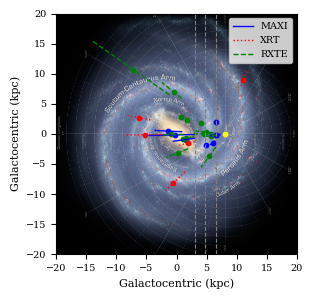

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.coordinates as apycoords
from mw_plot import MWFaceOn  # See https://milkyway-plot.readthedocs.io/

# --- Load CSV and ensure proper numeric conversion ---
csv_file = 'source_distance_mass_results_with_coords.csv'
df = pd.read_csv(csv_file)

# Convert the relevant columns to numeric
df['ra'] = pd.to_numeric(df['ra'], errors='coerce')
df['dec'] = pd.to_numeric(df['dec'], errors='coerce')
df['median_distance'] = pd.to_numeric(df['median_distance'], errors='coerce')
df['lower_distance_error'] = pd.to_numeric(df['lower_distance_error'], errors='coerce')
df['upper_distance_error'] = pd.to_numeric(df['upper_distance_error'], errors='coerce')

# --- Optionally, split the DataFrame by instrument ---
if 'instrument' in df.columns:
    df_maxi = df[df['instrument'] == 'MAXI']
    df_xrt  = df[df['instrument'] == 'XRT']
    df_rxte = df[df['instrument'] == 'RXTE_PCA']
else:
    df_maxi = df.copy()
    df_xrt = pd.DataFrame()
    df_rxte = pd.DataFrame()

def plot_distance_error(df_subset, color, label, linestyle):
    """
    For each source in the DataFrame subset, this function:
      - Computes the lower-bound position using (median_distance - lower_distance_error)
      - Computes the upper-bound position using (median_distance + upper_distance_error)
      - Computes the median position using median_distance
    It then transforms these into Galactocentric coordinates and plots:
      - A line (error bar) connecting the lower and upper positions (with the label)
      - A marker at the median position (without the label)
    
    Parameters
    ----------
    df_subset : pandas.DataFrame
        Must contain 'ra', 'dec', 'median_distance', 'lower_distance_error', and 'upper_distance_error' columns.
    color : str
        The color for both the error line and the marker.
    label : str
        The legend label (only applied for the first plotted line of this subset).
    linestyle : str
        The line style (e.g., '-', ':', '--') for the error bar.
    """
    # Create SkyCoord objects for lower, median, and upper distances
    c_lower = apycoords.SkyCoord(
        ra=df_subset['ra'].values * u.deg,
        dec=df_subset['dec'].values * u.deg,
        distance=(df_subset['median_distance'] - df_subset['lower_distance_error']).values * u.kpc,
        frame='icrs'
    )
    c_median = apycoords.SkyCoord(
        ra=df_subset['ra'].values * u.deg,
        dec=df_subset['dec'].values * u.deg,
        distance=df_subset['median_distance'].values * u.kpc,
        frame='icrs'
    )
    c_upper = apycoords.SkyCoord(
        ra=df_subset['ra'].values * u.deg,
        dec=df_subset['dec'].values * u.deg,
        distance=(df_subset['median_distance'] + df_subset['upper_distance_error']).values * u.kpc,
        frame='icrs'
    )
    
    # Transform to the Galactocentric frame
    gc_lower = c_lower.transform_to(apycoords.Galactocentric())
    gc_median = c_median.transform_to(apycoords.Galactocentric())
    gc_upper = c_upper.transform_to(apycoords.Galactocentric())
    
    # Loop over each source and plot the error line and marker.
    for i in range(len(df_subset)):
        # The negative sign is used to flip the coordinates for the face-on view.
        x_lower = -gc_lower.cartesian.x.value[i]
        y_lower = -gc_lower.cartesian.y.value[i]
        x_median = -gc_median.cartesian.x.value[i]
        y_median = -gc_median.cartesian.y.value[i]
        x_upper = -gc_upper.cartesian.x.value[i]
        y_upper = -gc_upper.cartesian.y.value[i]
        
        # Plot a line connecting the lower and upper positions.
        plt.plot([x_lower, x_upper], [y_lower, y_upper],
                 color=color, lw=1, linestyle=linestyle, label=label if i == 0 else None)
        # Plot a marker at the median position (without a label)
        plt.scatter(x_median, y_median, color=color, s=10)

# --- Set up the Milky Way face-on view using MWFaceOn ---
# This produces a bird's eye (face-on) view of the Galactic disc.
mw1 = MWFaceOn(radius=20 * u.kpc, unit=u.kpc, coord='galactocentric',
               annotation=True, figsize=(10/3, 3))

# Mark the Sun's location (assumed at 8.125 kpc along the x-axis)
mw1.scatter(8.125 * u.kpc, 0 * u.kpc, c='yellow', s=10)

# --- Plot the distance error bars for each instrument with different linestyles ---
plot_distance_error(df_maxi, color='b', label='MAXI', linestyle='-')  # solid line
if not df_xrt.empty:
    plot_distance_error(df_xrt, color='r', label='XRT', linestyle=':')   # dotted line
if not df_rxte.empty:
    plot_distance_error(df_rxte, color='g', label='RXTE', linestyle='--') # dashed line

# --- Add vertical dashed lines at x = -3.3, -4.0, and -7.5 kpc ---
# (Note: the negative sign is because x = -Galactocentric_x in this face-on view)
for x_val in [3,4.7, 6.5]:
    plt.axvline(x=x_val, color='gray', linestyle='--', lw=0.8)

plt.legend(fontsize=7)
plt.tight_layout()
# Optionally save the figure:
plt.savefig('mw_plot_modified.pdf', dpi=600,format='pdf', bbox_inches='tight')
# plt.savefig('mw_plot_modified.png', dpi=600, format='png', bbox_inches='tight')
plt.show()
